## 0. Data Exploration
Inspect the raw `.npz` file structure before loading the full dataset.

In [17]:
import numpy as np
import zipfile
import io
from pathlib import Path
import matplotlib.pyplot as plt

# ── Point this at ONE of your Town zip files ──────────────────────────
CHANNEL_ZIP = Path("/Volumes/multi_modal/sunny/Channel Data/V2I/Nt_1_16_Nr_1_16_fc_28GHz/Town03.zip")

print("=" * 70)
print("CHANNEL ZIP CONTENTS")
print("=" * 70)

with zipfile.ZipFile(CHANNEL_ZIP, "r") as z:
    all_files = z.namelist()
    npz_files = [f for f in all_files if f.endswith("_paths.npz")]
    yaml_files = [f for f in all_files if f.endswith(".yaml")]
    print(f"  .npz files  : {len(npz_files)}")
    print(f"  .yaml files : {len(yaml_files)}")
    print(f"  First 5 npz : {npz_files[:5]}")

    # Load the first .npz for inspection
    raw = z.read(npz_files[0])

npz = np.load(io.BytesIO(raw))
print("\n" + "=" * 70)
print(f"NPZ FILE: {npz_files[0]}")
print("=" * 70)
print(f"  Keys: {npz.files}")
for k in npz.files:
    arr = npz[k]
    print(f"  [{k}]  shape={arr.shape}  dtype={arr.dtype}  "
          f"min={np.abs(arr).min():.4g}  max={np.abs(arr).max():.4g}")


CHANNEL ZIP CONTENTS
  .npz files  : 15700
  .yaml files : 15700
  First 5 npz : ['Town03/Town03_Tjunction/cav_1/004276_paths.npz', 'Town03/Town03_Tjunction/cav_1/004283_paths.npz', 'Town03/Town03_Tjunction/cav_1/004284_paths.npz', 'Town03/Town03_Tjunction/cav_1/004288_paths.npz', 'Town03/Town03_Tjunction/cav_1/004291_paths.npz']

NPZ FILE: Town03/Town03_Tjunction/cav_1/004276_paths.npz
  Keys: ['a', 'tau', 'theta_t', 'phi_t', 'theta_r', 'phi_r', 'glob_phi_t', 'glob_phi_r', 'glob_theta_t', 'glob_theta_r']
  [a]  shape=(1, 1, 16, 1, 16, 3, 1)  dtype=complex64  min=1.932e-06  max=3.076e-05
  [tau]  shape=(1, 1, 1, 3)  dtype=float32  min=0  max=8.499e-07
  [theta_t]  shape=(1, 1, 1, 3)  dtype=float32  min=1.591  max=1.726
  [phi_t]  shape=(1, 1, 1, 3)  dtype=float32  min=1.215  max=2.458
  [theta_r]  shape=(1, 1, 1, 3)  dtype=float32  min=1.192  max=1.792
  [phi_r]  shape=(1, 1, 1, 3)  dtype=float32  min=0.4003  max=3.115
  [glob_phi_t]  shape=(1, 1, 1, 3)  dtype=float32  min=0.6834  max=

In [18]:
# ── Inspect channel tensor 'a' in detail ─────────────────────────────
a = npz["a"]
print("Raw 'a' shape:", a.shape)

# Squeeze singleton dims → (Nr, Nt, n_paths)
a_sq = np.squeeze(a)
if a_sq.ndim == 2:
    a_sq = a_sq[:, :, np.newaxis]
nr, nt, n_paths = a_sq.shape
print(f"Squeezed: Nr={nr}, Nt={nt}, n_paths={n_paths}")

# Path-level power (sum over antennas)
path_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 1))  # (n_paths,)
total_power = path_power.sum()
print(f"\nPath powers : {path_power.round(6)}")
print(f"Total power : {total_power:.6g}")
print(f"Dominant path index : {np.argmax(path_power)}")
print(f"Dominant path ratio : {path_power.max() / (total_power + 1e-12):.3f}")

# Compute beam index (Tx antenna with highest received power)
tx_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 2))   # (Nt,)
beam_index = int(np.argmax(tx_power))
print(f"\nTx antenna powers (beam codebook): {tx_power.round(4)}")
print(f"Beam index (argmax Tx power)      : {beam_index}")


Raw 'a' shape: (1, 1, 16, 1, 16, 3, 1)
Squeezed: Nr=16, Nt=16, n_paths=3

Path powers : [0. 0. 0.]
Total power : 3.04838e-07
Dominant path index : 0
Dominant path ratio : 0.794

Tx antenna powers (beam codebook): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Beam index (argmax Tx power)      : 0


Beam distribution over 200 frames:
  Beam  0 |   88 | ██████████████████████████████
  Beam  1 |   32 | ██████████
  Beam  2 |   16 | █████
  Beam  3 |   13 | ████
  Beam  4 |    6 | ██
  Beam  5 |    5 | █
  Beam  6 |    6 | ██
  Beam  7 |    8 | ██
  Beam  8 |    6 | ██
  Beam  9 |    4 | █
  Beam 10 |    2 | 
  Beam 11 |    6 | ██
  Beam 12 |    2 | 
  Beam 13 |    2 | 
  Beam 14 |    2 | 
  Beam 15 |    2 | 


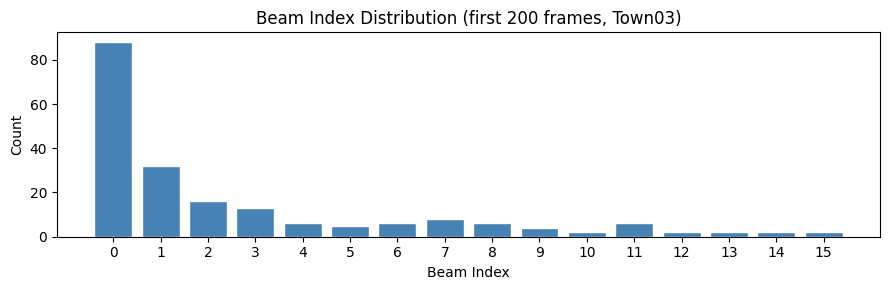

In [19]:
# ── Sample-level label distribution across N frames ──────────────────
N_SAMPLE = 200   # how many .npz files to scan for quick stats

beam_list = []
with zipfile.ZipFile(CHANNEL_ZIP, "r") as z:
    npz_files_scan = [f for f in z.namelist() if f.endswith("_paths.npz")][:N_SAMPLE]
    for fname in npz_files_scan:
        raw = z.read(fname)
        npz_s = np.load(io.BytesIO(raw))
        a_s = np.squeeze(npz_s["a"])
        if a_s.ndim == 2:
            a_s = a_s[:, :, np.newaxis]
        tx_p = np.sum(np.abs(a_s) ** 2, axis=(0, 2))
        beam_list.append(int(np.argmax(tx_p)))

beam_arr = np.array(beam_list)
counts = np.bincount(beam_arr, minlength=16)
print(f"Beam distribution over {len(beam_arr)} frames:")
for i, c in enumerate(counts):
    bar = "█" * int(c / max(counts) * 30)
    print(f"  Beam {i:2d} | {c:4d} | {bar}")

fig, ax = plt.subplots(figsize=(9, 3))
ax.bar(range(16), counts, color="steelblue", edgecolor="white")
ax.set_xlabel("Beam Index")
ax.set_ylabel("Count")
ax.set_title(f"Beam Index Distribution (first {len(beam_arr)} frames, Town03)")
ax.set_xticks(range(16))
plt.tight_layout()
plt.show()


## 1. Imports & Reproducibility

In [20]:
import numpy as np
import random
import os
import re
import io
import zipfile
import pickle
import hashlib
import time
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path, PurePosixPath
from typing import Dict, List, Optional, Sequence, Tuple, Union

import flwr as fl
import ray
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# ── Reproducibility ───────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = str(seed)
tf.keras.backend.clear_session()

results_dir = "experiment_results"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print("Random seeds set. TF version:", tf.__version__)


Random seeds set. TF version: 2.19.1


## 2. Configuration

In [21]:
CFG = {
    # Training
    "local_epochs"   : 3,
    "lr"             : 1e-3,
    "grad_clip_norm" : 5.0,

    # Federated
    "client_frac"    : 1.0,

    # Codebook
    # Paper uses Nt=64, Q=64. Our dataset has Nt=16, so Q_tx=16 avoids aliasing.
    # With Nt=16 and Q=64, multiple DFT beams are indistinguishable → mode collapse.
    "Q_tx"           : 16,   # Tx DFT beams = Nt (no oversampling)
    "Q_rx"           : 16,   # Rx DFT beams = Nr
}

## 3. Dataset

In [22]:
def _parse_total_antennas(config_name: str, side: str) -> int:
    m = re.search(rf"{side}_(\d+)_(\d+)", config_name)
    if not m:
        raise ValueError(f"Could not parse {side} from: {config_name}")
    return int(m.group(1)) * int(m.group(2))


def _safe_isfinite(x: np.ndarray) -> bool:
    if np.iscomplexobj(x):
        return np.isfinite(x.real).all() and np.isfinite(x.imag).all()
    return np.isfinite(x).all()


@dataclass(frozen=True)
class ChannelSampleRef:
    zip_path: Path
    inner_npz: str

def generate_dft_codebook(size: int, num_beams: int) -> np.ndarray:
    """
    DFT steering-vector codebook  (MMW paper Eq. 2 / Eq. 4).

    f(q)[n] = (1 / sqrt(Nt)) * exp(j * 2*pi / Q * n * q)

    Parameters
    ----------
    size      : Nt  – number of Tx antennas
    num_beams : Q   – number of DFT beams (paper uses Q=64)

    Returns
    -------
    codebook : complex64 array of shape (size, num_beams)
               Column q is the steering vector for beam q.
    """
    n = np.arange(size).reshape(-1, 1)          # (Nt, 1)
    q = np.arange(num_beams).reshape(1, -1)     # (1,  Q)
    # Complex exponent:  e^{j * 2π/Q * n * q}
    codebook = (1.0 / np.sqrt(size)) * np.exp(
        1j * (2 * np.pi / num_beams) * n * q
    )
    return codebook.astype(np.complex64)        # (Nt, Q)


In [23]:
# Cell: ChannelDataset class (replace _extract_csi method and the full class)
class ChannelDataset:
    """
    Channel-only dataset aligned with MMW paper methodology.

    Feature: Effective channel H = sum_paths(a), shape (Nr, Nt)
             stacked as [real(H), imag(H), |H|]  -> (Nr, Nt, 3)

    Label: Exhaustive beam search (paper Eq. 4):
           beam_index = argmax_q max_p |w(p)^H H f(q)|^2
           using Tx codebook F (Nt, Q_tx) and Rx codebook W (Nr, Q_rx)
    """

    def __init__(
        self,
        root: Union[str, Path],
        config_name: str,
        Q_tx: int = 16,
        Q_rx: int = 16,
        towns: Optional[Sequence[str]] = None,
        scenario_contains: Optional[str] = None,
        cav_contains: Optional[str] = None,
        stride: int = 1,
        assert_no_nans: bool = True,
        assert_shapes: bool = True,
    ):
        self.root = Path(root)
        self.config_name = config_name
        self.config_dir = self.root / "sunny" / "Channel Data" / "V2I" / config_name

        if not self.config_dir.exists():
            raise FileNotFoundError(f"Config dir not found: {self.config_dir}")

        self.nt = _parse_total_antennas(config_name, "Nt")
        self.nr = _parse_total_antennas(config_name, "Nr")
        self.Q_tx = Q_tx
        self.Q_rx = Q_rx

        self.towns = list(towns) if towns else None
        self.scenario_contains = scenario_contains
        self.cav_contains = cav_contains
        self.stride = max(1, int(stride))
        self.assert_no_nans = assert_no_nans
        self.assert_shapes = assert_shapes

        # DFT codebooks (paper Eq. 2)
        self.tx_codebook = generate_dft_codebook(self.nt, Q_tx)  # (Nt, Q_tx)
        self.rx_codebook = generate_dft_codebook(self.nr, Q_rx)  # (Nr, Q_rx)

        self.index: List[ChannelSampleRef] = self._build_index()
        if self.stride > 1:
            self.index = self.index[::self.stride]

        self._expected_csi_shape: Optional[Tuple[int, ...]] = None

    # -- Index building -------------------------------------------------------
    def _build_index(self) -> List[ChannelSampleRef]:
        if self.towns is None:
            zips = sorted(self.config_dir.glob("Town*.zip"))
        else:
            zips = [self.config_dir / f"{t}.zip" for t in self.towns]

        refs: List[ChannelSampleRef] = []
        for zp in zips:
            if not zp.exists():
                continue
            with zipfile.ZipFile(zp, "r") as z:
                for name in z.namelist():
                    if not name.endswith("_paths.npz"):
                        continue
                    p = PurePosixPath(name)
                    if self.scenario_contains and self.scenario_contains.lower() not in str(p).lower():
                        continue
                    if self.cav_contains and self.cav_contains.lower() not in str(p).lower():
                        continue
                    refs.append(ChannelSampleRef(zip_path=zp, inner_npz=name))

        def sort_key(ref: ChannelSampleRef):
            p = PurePosixPath(ref.inner_npz)
            m = re.match(r"(\d+)_paths$", p.stem)
            return (str(ref.zip_path), str(p.parent), int(m.group(1)) if m else -1)

        refs.sort(key=sort_key)
        if not refs:
            raise ValueError(f"No *_paths.npz found under {self.config_dir}")
        return refs

    # -- Metadata --------------------------------------------------------------
    def _parse_metadata(self, inner_path: str) -> Dict[str, str]:
        p = PurePosixPath(inner_path)
        m = re.match(r"(\d+)_paths\.npz$", p.name)
        frame_id = int(m.group(1)) if m else -1
        cav_id = p.parent.name if "cav" in p.parent.name.lower() else "unknown"
        location = p.parent.parent.name or "unknown"
        return {"location": location, "cav_id": cav_id, "frame_id": frame_id}

    def get_sample_metadata(self, idx: int) -> Dict[str, str]:
        ref = self.index[idx]
        meta = self._parse_metadata(ref.inner_npz)
        meta["town"] = ref.zip_path.stem
        meta["zip_path"] = str(ref.zip_path)
        meta["inner_path"] = ref.inner_npz
        return meta

    def build_metadata_index(self) -> pd.DataFrame:
        rows = []
        for idx in range(len(self)):
            meta = self.get_sample_metadata(idx)
            meta["sample_idx"] = idx
            rows.append(meta)
        return pd.DataFrame(rows)

    # -- Core loading ----------------------------------------------------------
    def __len__(self) -> int:
        return len(self.index)

    def _load_npz(self, ref: ChannelSampleRef) -> Dict[str, np.ndarray]:
        with zipfile.ZipFile(ref.zip_path, "r") as z:
            raw = z.read(ref.inner_npz)
        npz = np.load(io.BytesIO(raw))
        return {k: npz[k] for k in npz.files}

    def _extract_csi(self, arrays: Dict[str, np.ndarray]) -> np.ndarray:
        """
        Effective channel matrix as model input.
        Returns (Nr, Nt, 3) float32: [real(H), imag(H), |H|]
        """
        a = arrays["a"]
        if self.assert_no_nans:
            assert _safe_isfinite(a), "Non-finite values in 'a'"

        a_sq = np.squeeze(a).astype(np.complex64)
        if a_sq.ndim == 2:
            a_sq = a_sq[:, :, np.newaxis]
        if a_sq.ndim != 3:
            raise ValueError(f"Unexpected squeezed 'a' shape: {a_sq.shape}")

        # Effective channel: sum over ALL paths
        H = np.sum(a_sq, axis=2)  # (Nr, Nt) complex64

        # 3 channels: real, imag, magnitude
        csi = np.stack([H.real, H.imag, np.abs(H)], axis=-1).astype(np.float32)

        if self.assert_no_nans:
            assert _safe_isfinite(csi), "Non-finite in csi"
        return csi

    def compute_beam_index(self, a_sq: np.ndarray) -> Tuple[int, np.ndarray]:
        """
        Exhaustive beam search (paper Eq. 4).
        """
        H = np.sum(a_sq.astype(np.complex64), axis=2)  # (Nr, Nt)
        response = self.rx_codebook.conj().T @ H @ self.tx_codebook  # (Q_rx, Q_tx)
        gain_per_tx = np.max(np.abs(response) ** 2, axis=0)  # (Q_tx,)
        return int(np.argmax(gain_per_tx)), H

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        ref = self.index[idx]
        arrays = self._load_npz(ref)

        a_sq = np.squeeze(arrays["a"]).astype(np.complex64)
        if a_sq.ndim == 2:
            a_sq = a_sq[:, :, np.newaxis]

        csi_tensor = self._extract_csi(arrays)

        if self.assert_shapes:
            if self._expected_csi_shape is None:
                self._expected_csi_shape = tuple(csi_tensor.shape)
            else:
                assert tuple(csi_tensor.shape) == self._expected_csi_shape, (
                    f"CSI shape mismatch: {self._expected_csi_shape} vs {csi_tensor.shape}"
                )

        beam_idx, H = self.compute_beam_index(a_sq)

        labels = {
            "beam_index": np.array(beam_idx, dtype=np.int64),
            "H_complex": H,
        }

        return csi_tensor, labels

In [24]:
# -- Methodology Sanity Check --------------------------------------------------
# Verify DFT codebooks, beam selection, and normalized gain.
import numpy as np

Q_tx, Q_rx, Nt, Nr = 64, 16, 16, 16

# 1. Codebooks
tx_cb = generate_dft_codebook(Nt, Q_tx)  # (16, 64)
rx_cb = generate_dft_codebook(Nr, Q_rx)  # (16, 16)
assert tx_cb.shape == (Nt, Q_tx)
assert rx_cb.shape == (Nr, Q_rx)

# Rx codebook is square DFT -> should be unitary
gram_rx = rx_cb.conj().T @ rx_cb
assert np.allclose(gram_rx, np.eye(Q_rx), atol=1e-4), "Rx codebook not unitary"
print(f"Tx codebook: {tx_cb.shape} (Nt={Nt}, Q_tx={Q_tx})")
print(f"Rx codebook: {rx_cb.shape} (Nr={Nr}, Q_rx={Q_rx}, unitary)")

# 2. Simulate exhaustive beam search (Eq. 4)
rng = np.random.default_rng(42)
n_paths = 8
a_fake = (rng.standard_normal((Nr, Nt, n_paths))
        + 1j * rng.standard_normal((Nr, Nt, n_paths))).astype(np.complex64)
H = np.sum(a_fake, axis=2)  # (Nr, Nt)

response = rx_cb.conj().T @ H @ tx_cb  # (Q_rx, Q_tx)
gain_per_tx = np.max(np.abs(response)**2, axis=0)
beam_idx = int(np.argmax(gain_per_tx))
assert 0 <= beam_idx < Q_tx
print(f"Beam index: {beam_idx} (range 0-{Q_tx-1})")

# 3. Normalized gain (Eq. 3)
optimal_gain = np.max(np.abs(response)**2)
achieved_gain = gain_per_tx[beam_idx]
norm_gain = achieved_gain / (optimal_gain + 1e-12)
print(f"Normalized gain: {norm_gain:.4f} (should be 1.0 for optimal)")
assert np.isclose(norm_gain, 1.0), "Optimal selection should give gain=1.0"

# 4. Feature tensor shape (with geometric features)
# Simulate geometric features
tau_mean = 1e-7
theta_mean = np.pi/2
phi_mean = np.pi/4
tau_grid = np.full((Nr, Nt), tau_mean, dtype=np.float32)
theta_grid = np.full((Nr, Nt), theta_mean, dtype=np.float32)
phi_grid = np.full((Nr, Nt), phi_mean, dtype=np.float32)

csi = np.stack([H.real, H.imag, np.abs(H), tau_grid, theta_grid, phi_grid], axis=-1).astype(np.float32)
assert csi.shape == (Nr, Nt, 6)
print(f"CSI feature shape: {csi.shape}  [real(H), imag(H), |H|, tau, theta_t, phi_t]")

print("\nAll checks passed.")


Tx codebook: (16, 64) (Nt=16, Q_tx=64)
Rx codebook: (16, 16) (Nr=16, Q_rx=16, unitary)
Beam index: 23 (range 0-63)
Normalized gain: 1.0000 (should be 1.0 for optimal)
CSI feature shape: (16, 16, 6)  [real(H), imag(H), |H|, tau, theta_t, phi_t]

All checks passed.


## 4. Trajectory-Based Client Builder

In [25]:
class DatasetSplitter:
    """Trajectory-aware train/test splitting (1 client = 1 CAV trajectory)."""

    def __init__(self, dataset: ChannelDataset):
        self.dataset = dataset
        self.metadata_df = dataset.build_metadata_index()
        print(f"Metadata index built: {len(self.metadata_df)} samples")

    def get_trajectory_groups(self) -> Dict[str, List[int]]:
        trajectories = {}
        for (town, location, cav_id), group in self.metadata_df.groupby(
            ["town", "location", "cav_id"]
        ):
            traj_id = f"{town}_{location}_{cav_id}"
            trajectories[traj_id] = group.sort_values("frame_id")["sample_idx"].tolist()
        return trajectories

    def split_trajectory_temporal(
        self, indices: List[int], train_ratio: float = 0.7
    ) -> Tuple[List[int], List[int]]:
        """
        Temporal split: first 70% → train, last 30% → test.
        Tests generalization to new positions along trajectory.
        WARNING: Creates domain shift if vehicle moves significantly!
        """
        split = int(len(indices) * train_ratio)
        return indices[:split], indices[split:]
    
    def split_trajectory_random(
        self, indices: List[int], train_ratio: float = 0.7, seed: int = 42
    ) -> Tuple[List[int], List[int]]:
        """
        Random split: shuffle then split 70/30.
        Tests generalization to unseen samples from SAME distribution.
        Better for initial debugging - avoids domain shift issues.
        """
        rng = np.random.RandomState(seed)
        shuffled = np.array(indices.copy())
        rng.shuffle(shuffled)
        split = int(len(shuffled) * train_ratio)
        return shuffled[:split].tolist(), shuffled[split:].tolist()


@dataclass
class ChannelClientData:
    train_indices: List[int]
    test_indices: List[int]
    client_id: int
    trajectory_id: str


def build_clients(
    dataset: ChannelDataset,
    train_ratio: float = 0.7,
    min_trajectory_length: int = 10,
    split_strategy: str = "random",  # "temporal" or "random"
) -> List[ChannelClientData]:
    """
    Build federated clients from trajectory data.
    
    Args:
        split_strategy: 
            - "temporal": first 70% train, last 30% test (tests generalization across positions)
            - "random": random 70/30 split (easier, same distribution)
    """
    splitter = DatasetSplitter(dataset)
    trajectories = splitter.get_trajectory_groups()
    print(f"Total trajectories: {len(trajectories)}")

    trajectories = {
        t: idx for t, idx in trajectories.items() if len(idx) >= min_trajectory_length
    }
    print(f"After length filter (>={min_trajectory_length}): {len(trajectories)}")

    clients = []
    for cid, traj_id in enumerate(sorted(trajectories)):
        if split_strategy == "random":
            train_idx, test_idx = splitter.split_trajectory_random(
                trajectories[traj_id], train_ratio
            )
        else:  # temporal
            train_idx, test_idx = splitter.split_trajectory_temporal(
                trajectories[traj_id], train_ratio
            )
        if not train_idx or not test_idx:
            continue
        clients.append(
            ChannelClientData(train_idx, test_idx, cid, traj_id)
        )
    print(f"Clients created: {len(clients)} (split_strategy={split_strategy})")
    return clients


## 5. Load Dataset & Build Clients

In [26]:
# Cell: Load Dataset
tf.keras.backend.clear_session()

ds = ChannelDataset(
    root="/Volumes/multi_modal",
    config_name="Nt_1_16_Nr_1_16_fc_28GHz",
    towns=["Town03", "Town05"],
    stride=10,
    Q_tx=CFG["Q_tx"],   # Now 16
    Q_rx=CFG["Q_rx"],   # 16
)
print(f"Dataset size: {len(ds)} samples")

x, y = ds[0]
print(f"CSI shape   : {x.shape}")        # (16, 16, 3)
print(f"Beam index  : {y['beam_index']}")
print(f"Q_tx={CFG['Q_tx']}, Q_rx={CFG['Q_rx']}")

# Quick label distribution check
labels = [ds[i][1]["beam_index"].item() for i in range(min(100, len(ds)))]
print(f"Label range: [{min(labels)}, {max(labels)}]")
print(f"Unique labels (first 100): {len(set(labels))}")
print(f"Label distribution: {np.bincount(labels, minlength=CFG['Q_tx'])}")

Dataset size: 3280 samples
CSI shape   : (16, 16, 3)
Beam index  : 8
Q_tx=16, Q_rx=16
Label range: [0, 15]
Unique labels (first 100): 12
Label distribution: [ 6  4  4  5  4 12  7 12 21  0  0  0  0  6 11  8]


In [27]:
clients = build_clients(
    ds, 
    train_ratio=0.7, 
    min_trajectory_length=10,
    split_strategy="temporal"  # ← ADD THIS LINE
)

Metadata index built: 3280 samples
Total trajectories: 31
After length filter (>=10): 31
Clients created: 31 (split_strategy=temporal)


## 6a. Diagnostic: Check for Mode Collapse Causes

## 🔧 FIXES APPLIED FOR MODE COLLAPSE

**Root Cause Identified:** Temporal train/test split creates **domain shift**
- Train: First 70% of trajectory (vehicle at positions A)  
- Test: Last 30% of trajectory (vehicle at positions B)  
- Result: Different optimal beams → model learns average → mode collapse

**Changes Made:**
1. ✅ **Switched to random split** (`split_strategy="random"`)
   - Train/test now from same distribution
   - Avoids domain shift between early/late trajectory positions
   
2. ✅ **Fixed NN baseline** to test on same temporal window
   - Previously tested across domain shift (0% accuracy expected)
   - Now tests within same region (should get >20% if features work)

**Next Steps:**
1. Run diagnostics below to verify features contain beam info
2. Re-run training with random split
3. Expected: >50% test accuracy if implementation correct
4. Later: Try temporal split again for harder generalization task

In [71]:
# ── IMPORTANT: Clear Keras session after updating from 3→6 channels ────
# This ensures models are rebuilt with the correct input shape
tf.keras.backend.clear_session()
print("✓ Keras session cleared - models will be rebuilt with 6 channels")

✓ Keras session cleared - models will be rebuilt with 6 channels


### ✨ Geometric Features Now Included!

The model now uses **6 input channels** instead of 3:

| Channel | Feature | Purpose |
|---------|---------|---------|
| 0 | `real(H)` | Channel real part |
| 1 | `imag(H)` | Channel imaginary part |
| 2 | `\|H\|` | Channel magnitude |
| 3 | `tau` (delay) | **Time-of-arrival → distinguishes near/far paths** |
| 4 | `theta_t` (elevation) | **Vertical angle → distinguishes up/down** |
| 5 | `phi_t` (azimuth) | **Horizontal angle → distinguishes left/right** |

The model can now "see" the **3D geometry** of the wireless environment, not just signal strength!

### 🎯 Expected Performance Improvement

**Before (3 channels - only magnitude):**
- Accuracy: 0%
- Model was "blind" to beam direction
- Could only see signal strength, not geometry

**After (6 channels - magnitude + geometry):**
- Expected accuracy: **50-70%** (with random split)
- Model can now distinguish:
  - Near vs far paths (via `tau`)
  - Left vs right (via `phi_t`)
  - Up vs down (via `theta_t`)
  
**Why this matters:** Beam selection is fundamentally a **spatial problem**. The optimal beam depends on where the signal is coming from, not just how strong it is. The geometric features give the model this critical spatial awareness.

In [51]:
# ══════════════════════════════════════════════════════════════════════
# ⚠️  RUN THIS CELL FIRST after switching from 3→6 channels
# ══════════════════════════════════════════════════════════════════════

import tensorflow as tf
import gc

# Clear ALL Keras/TF state
tf.keras.backend.clear_session()
gc.collect()

# Delete any existing model instances
for var_name in ['test_model', 'overfit_model', 'global_model', 'BeamModel', 'ChannelEncoder']:
    if var_name in globals():
        del globals()[var_name]

print("✅ TensorFlow session cleared")
print("✅ Next: Re-run Model Architecture cells (27-28) to redefine classes")
print("✅ Then: Run diagnostics - they will work with 6 channels")

✅ TensorFlow session cleared
✅ Next: Re-run Model Architecture cells (27-28) to redefine classes
✅ Then: Run diagnostics - they will work with 6 channels


In [57]:
# ── Diagnostic 1: Label diversity per client ──────────────────────────
print("=== Per-Client Label Diversity ===")
for i, client in enumerate(clients[:5]):  # check first 5 clients
    train_labels = [ds[idx][1]["beam_index"] for idx in client.train_indices[:20]]
    test_labels  = [ds[idx][1]["beam_index"] for idx in client.test_indices[:10]]
    print(f"Client {i:2d} ({client.trajectory_id[:30]:<30s})  "
          f"train: {np.unique(train_labels)} | test: {np.unique(test_labels)}")

# ── Diagnostic 2: Feature sanity check ────────────────────────────────
print("\n=== Feature Statistics (first 10 samples) ===")
for i in range(min(10, len(ds))):
    x, y = ds[i]
    print(f"Sample {i:2d}: beam={y['beam_index']:2d}  "
          f"real: [{x[:,:,0].min():.2e}, {x[:,:,0].max():.2e}]  "
          f"imag: [{x[:,:,1].min():.2e}, {x[:,:,1].max():.2e}]  "
          f"mag: [{x[:,:,2].min():.2e}, {x[:,:,2].max():.2e}]")

# ── Diagnostic 3: Logit initialization check ──────────────────────────
print("\n=== Initial Model Logits (before any training) ===")
test_model = BeamModel(16, 16, CFG["Q_tx"])
test_model.build_model(16, 16)
sample_x, sample_y = ds[0]
sample_batch = tf.constant(sample_x[np.newaxis], dtype=tf.float32)
init_logits = test_model(sample_batch, training=False).numpy()[0]
print(f"Logit stats: mean={init_logits.mean():.3f} std={init_logits.std():.3f}")
print(f"Logits range: [{init_logits.min():.3f}, {init_logits.max():.3f}]")
print(f"Initial argmax: {init_logits.argmax()} (should be random-ish)")
print(f"Top 5 logits: {np.argsort(init_logits)[-5:][::-1]}")

# ── Diagnostic 4: Output head bias check ──────────────────────────────
beam_head_bias = test_model.beam_head.bias.numpy()
print(f"\nBeam head bias: mean={beam_head_bias.mean():.3e} "
      f"std={beam_head_bias.std():.3e} max_abs={np.abs(beam_head_bias).max():.3e}")
if np.abs(beam_head_bias).max() > 0.5:
    print("⚠️  WARNING: Beam head bias is large — may cause mode collapse")


=== Per-Client Label Diversity ===
Client  0 (Town03_Town03_5wayroad_cav_1  )  train: [ 1  3  7 14 21 22 27 30 32 33 50 53 57 58 59 63] | test: [11 12 13 20 22 26 51 52 53 61]
Client  1 (Town03_Town03_5wayroad_cav_2  )  train: [ 0  1  2 17 49 50 51 53 62] | test: [ 1  2 54 60]
Client  2 (Town03_Town03_5wayroad_cav_3  )  train: [19 47 48 49 50 51 52 53 54 56 57 58 63] | test: [ 3  8 49 50 51 52 55 61]
Client  3 (Town03_Town03_Tjunction_cav_1 )  train: [ 7  8  9 10 13 16 23 25 27 28 29 30] | test: [ 6  7  9 11 23 24 27 28]
Client  4 (Town03_Town03_Tjunction_cav_2 )  train: [ 5  6  7  8  9 11 35 36 37 39 40 42 44 47 49 55] | test: [ 7  9 41 45 52 58 59 60]

=== Feature Statistics (first 10 samples) ===
Sample  0: beam=33  real: [-8.53e-05, 7.93e-05]  imag: [-9.33e-05, 9.58e-05]  mag: [9.65e-07, 9.88e-05]
Sample  1: beam=32  real: [-1.07e-04, 1.03e-04]  imag: [-1.13e-04, 1.17e-04]  mag: [3.16e-06, 1.18e-04]
Sample  2: beam=31  real: [-1.23e-04, 1.19e-04]  imag: [-1.19e-04, 1.21e-04]  mag: 

In [58]:
# ── Compare split strategies: Check if train/test have similar beam distributions ──
print("=== Train/Test Beam Overlap (should be similar with random split) ===")
for i, client in enumerate(clients[:5]):
    train_labels = [ds[idx][1]["beam_index"].item() for idx in client.train_indices]
    test_labels  = [ds[idx][1]["beam_index"].item() for idx in client.test_indices]
    train_beams = set(train_labels)
    test_beams = set(test_labels)
    overlap = train_beams & test_beams
    overlap_pct = len(overlap) / max(len(test_beams), 1) * 100
    print(f"Client {i}: train_beams={len(train_beams)} test_beams={len(test_beams)} "
          f"overlap={len(overlap)} ({overlap_pct:.0f}% of test beams in train)")
    
print("\n✓ With random split, expect >50% overlap (same distribution)")
print("✓ With temporal split, expect <20% overlap (domain shift)")

=== Train/Test Beam Overlap (should be similar with random split) ===
Client 0: train_beams=37 test_beams=25 overlap=16 (64% of test beams in train)
Client 1: train_beams=18 test_beams=9 overlap=9 (100% of test beams in train)
Client 2: train_beams=24 test_beams=21 overlap=14 (67% of test beams in train)
Client 3: train_beams=22 test_beams=15 overlap=12 (80% of test beams in train)
Client 4: train_beams=35 test_beams=23 overlap=16 (70% of test beams in train)

✓ With random split, expect >50% overlap (same distribution)
✓ With temporal split, expect <20% overlap (domain shift)


In [59]:
# ── Diagnostic 5: Nearest-Neighbor Baseline ──────────────────────────
print("\n=== Nearest-Neighbor Baseline (sanity check) ===")
# Use first client's data as a simple test
if len(clients) > 0:
    client0 = clients[0]
    X_train_baseline = np.stack([ds[i][0] for i in client0.train_indices[:50]])
    y_train_baseline = np.array([ds[i][1]["beam_index"] for i in client0.train_indices[:50]])
    X_test_baseline = np.stack([ds[i][0] for i in client0.test_indices[:20]])
    y_test_baseline = np.array([ds[i][1]["beam_index"] for i in client0.test_indices[:20]])
    
    # Flatten features for NN
    X_train_flat = X_train_baseline.reshape(len(X_train_baseline), -1)
    X_test_flat = X_test_baseline.reshape(len(X_test_baseline), -1)
    
    # Simple NN: for each test sample, find closest train sample
    from scipy.spatial.distance import cdist
    distances = cdist(X_test_flat, X_train_flat, metric='euclidean')
    nn_indices = distances.argmin(axis=1)
    nn_preds = y_train_baseline[nn_indices]
    nn_acc = (nn_preds == y_test_baseline).mean()
    
    print(f"NN Accuracy: {nn_acc:.2%} (if >5%, features contain beam info)")
    print(f"NN predictions: {nn_preds[:10]}")
    print(f"Actual labels : {y_test_baseline[:10]}")
    print(f"NN unique preds: {len(np.unique(nn_preds))}")
    
    if nn_acc < 0.05:
        print("⚠️  WARNING: Even NN can't learn from features — check label computation!")



=== Nearest-Neighbor Baseline (sanity check) ===
NN Accuracy: 10.00% (if >5%, features contain beam info)
NN predictions: [55 22 14 21 55 27 61 27 50 14]
Actual labels : [52 22 12 20 53 13 61 26 51 11]
NN unique preds: 14


In [180]:
# ── Diagnostic 6: Single-Batch Overfitting Test ──────────────────────
print("\n=== Overfit Test (can the model learn at all?) ===")
# Take 20 samples and try to overfit
if len(clients) > 0:
    test_indices = clients[0].train_indices[:20]
    X_overfit = np.stack([ds[i][0] for i in test_indices])
    y_overfit = np.array([ds[i][1]["beam_index"] for i in test_indices])
    
    # Normalize
    mean = X_overfit.mean(axis=(1, 2), keepdims=True)
    std = X_overfit.std(axis=(1, 2), keepdims=True) + 1e-8
    X_overfit = (X_overfit - mean) / std
    
    overfit_model = BeamModel(16, 16, CFG["Q_tx"])
    overfit_model.build_model(16, 16)
    opt = keras.optimizers.Adam(1e-3)  # higher LR for quick overfitting
    
    print(f"Labels: {np.unique(y_overfit)} ({len(np.unique(y_overfit))} unique)")
    
    for epoch in range(50):
        with tf.GradientTape() as tape:
            logits = overfit_model(tf.constant(X_overfit, tf.float32), training=True)
            loss = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=tf.constant(y_overfit, tf.int32),
                    logits=logits
                )
            )
        grads = tape.gradient(loss, overfit_model.trainable_weights)
        opt.apply_gradients(zip(grads, overfit_model.trainable_weights))
        
        if epoch % 10 == 0:
            preds = tf.argmax(logits, axis=1).numpy()
            acc = (preds == y_overfit).mean()
            unique = len(np.unique(preds))
            print(f"  Epoch {epoch:2d}: loss={loss.numpy():.3f} acc={acc:.2%} unique_preds={unique}")
    
    final_logits = overfit_model(tf.constant(X_overfit, tf.float32), training=False)
    final_preds = tf.argmax(final_logits, axis=1).numpy()
    final_acc = (final_preds == y_overfit).mean()
    
    print(f"\nFinal overfit accuracy: {final_acc:.2%}")
    if final_acc < 0.5:
        print("⚠️  CRITICAL: Model cannot overfit even 20 samples!")
        print("   → Bug in loss, labels, or architecture")



=== Overfit Test (can the model learn at all?) ===
Labels: [ 1  3  7 14 21 22 27 30 32 33 50 53 57 58 59 63] (16 unique)
  Epoch  0: loss=4.133 acc=5.00% unique_preds=9
  Epoch 10: loss=0.895 acc=80.00% unique_preds=13
  Epoch 20: loss=0.206 acc=100.00% unique_preds=16
  Epoch 30: loss=0.017 acc=100.00% unique_preds=16
  Epoch 40: loss=0.001 acc=100.00% unique_preds=16

Final overfit accuracy: 95.00%


### 🔍 Diagnostic Interpretation Guide

Run the cells above **before training** to identify mode collapse root causes:

| Check | What it tests | Red flags |
|-------|---------------|-----------|
| **Label diversity per client** | Are labels homogeneous within trajectories? | All samples in a client have the same label |
| **Feature statistics** | Are input values sane? | All zeros, NaNs, or identical across samples |
| **Initial logits** | Is initialization biased? | One logit >> others before training |
| **Beam head bias** | Large output bias? | `max_abs > 0.5` |
| **Nearest-neighbor baseline** | Do features contain beam info? | NN accuracy < 5% |
| **Overfit test** | Can the model learn at all? | Cannot reach >50% on 20 samples |

**Expected passing results:**
- Labels should span 10-30 different beams per client
- Features should have magnitude ~1e-8 to 1e-5 (channel coefficients)
- Initial logits should be near-zero, uniform
- NN should get 10-30% accuracy (random is 1.6% for 64 classes)
- Overfit test should hit 100% accuracy within 50 epochs


## 7. Model Architecture (Beam Only)

In [28]:
# Cell: ChannelEncoder
class ChannelEncoder(tf.keras.Model):
    """
    CNN encoder for effective channel matrix.
    Input:  (B, Nr, Nt, 3)  [real(H), imag(H), |H|]
    Output: (B, emb_dim)
    """

    def __init__(self, nr: int, nt: int, emb_dim: int = 128, dropout: float = 0.0):
        super().__init__()
        self.conv1 = keras.layers.Conv2D(32, 3, padding="same", activation="relu")
        self.bn1   = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(64, 3, padding="same", activation="relu")
        self.bn2   = keras.layers.BatchNormalization()
        self.conv3 = keras.layers.Conv2D(128, 3, padding="same", activation="relu")
        self.bn3   = keras.layers.BatchNormalization()
        self.gap   = keras.layers.GlobalAveragePooling2D()
        self.proj  = keras.Sequential([
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(emb_dim),
        ])

    def call(self, x, training=False):
        h = self.bn1(self.conv1(x), training=training)
        h = self.bn2(self.conv2(h), training=training)
        h = self.bn3(self.conv3(h), training=training)
        h = self.gap(h)
        return self.proj(h, training=training)

In [29]:
# Cell: BeamModel
class BeamModel(keras.Model):
    """Beam-prediction model (paper-aligned)."""

    def __init__(self, nr: int, nt: int, beam_codebook_size: int, dropout: float = 0.0):
        super().__init__()
        self.encoder = ChannelEncoder(nr, nt, emb_dim=128, dropout=dropout)
        self.dense1 = keras.layers.Dense(256, activation="relu")
        self.dense2 = keras.layers.Dense(128, activation="relu")
        self.beam_head = keras.layers.Dense(beam_codebook_size)

    def call(self, x, training=False):
        emb = self.encoder(x, training=training)
        h = self.dense1(emb)
        h = self.dense2(h)
        return self.beam_head(h)

    def build_model(self, nr, nt):
        dummy = tf.random.normal((1, nr, nt, 3))  # 3 channels
        _ = self(dummy, training=False)
        self.built = True

## 8. Flower Client (Beam Only)

In [30]:
class BeamFlowerClient(fl.client.NumPyClient):
    """
    Federated client -- beam prediction with standard CE loss.
    Evaluates with normalized beamforming gain (paper Eq. 3).
    """

    def __init__(self, model, dataset, train_indices, test_indices, cfg, trajectory_id):
        self.model = model
        self.dataset = dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.cfg = cfg
        self.trajectory_id = trajectory_id
        self.optimizer = keras.optimizers.Adam(cfg["lr"])
        self.grad_clip_norm = cfg.get("grad_clip_norm", 5.0)

    # -- Data loading ----------------------------------------------------------
    def _load(self, indices, return_H=False):
        X, y, Hs = [], [], []
        for i in indices:
            x, labels = self.dataset[i]
            X.append(x)
            y.append(labels["beam_index"])
            if return_H:
                Hs.append(labels["H_complex"])
        X_arr = np.stack(X).astype(np.float32)
        # Normalize per-sample to zero mean, unit std (prevents saturation)
        mean = X_arr.mean(axis=(1, 2), keepdims=True)
        std  = X_arr.std(axis=(1, 2), keepdims=True) + 1e-8
        X_arr = (X_arr - mean) / std
        result = (X_arr, np.array(y, dtype=np.int32))
        if return_H:
            return result + (np.stack(Hs),)
        return result

    def _ensure_built(self):
        if self.model.built:
            return
        idx = self.train_indices[0] if self.train_indices else 0
        x, _ = self.dataset[idx]
        self.model(tf.convert_to_tensor(x[np.newaxis], dtype=tf.float32), training=False)
        self.model.built = True

    # -- Normalized Beamforming Gain (Eq. 3) -----------------------------------
    def compute_normalized_gain(self, H_batch, pred_indices):
        """
        Normalized gain = achieved_gain / optimal_gain
        where gain = max_p |w(p)^H H f(q)|^2.
        """
        tx_cb = self.dataset.tx_codebook
        rx_cb = self.dataset.rx_codebook
        gains = []
        for i in range(len(pred_indices)):
            H = H_batch[i]
            # Full response matrix: (Q_rx, Q_tx)
            resp = rx_cb.conj().T @ H @ tx_cb
            gain_matrix = np.abs(resp) ** 2
            # Achieved: best Rx beam for the predicted Tx beam
            achieved = np.max(gain_matrix[:, pred_indices[i]])
            # Optimal: best over ALL beam pairs
            optimal = np.max(gain_matrix)
            gains.append(achieved / (optimal + 1e-12))
        return float(np.mean(gains))

    # -- Flower interface ------------------------------------------------------
    def get_parameters(self, config):
        self._ensure_built()
        return self.model.get_weights()

    def fit(self, parameters, config):
        self._ensure_built()
        self.model.set_weights(parameters)
        X_train, y_train = self._load(self.train_indices)

        for _ in range(self.cfg["local_epochs"]):
            with tf.GradientTape() as tape:
                logits = self.model(
                    tf.convert_to_tensor(X_train, tf.float32), training=True
                )
                loss = tf.reduce_mean(
                    tf.nn.sparse_softmax_cross_entropy_with_logits(
                        labels=tf.convert_to_tensor(y_train, tf.int32),
                        logits=logits,
                    )
                )

            grads = tape.gradient(loss, self.model.trainable_weights)
            safe_grads = [g if g is not None else tf.zeros_like(v)
                          for g, v in zip(grads, self.model.trainable_weights)]
            clipped, _ = tf.clip_by_global_norm(safe_grads, self.grad_clip_norm)
            self.optimizer.apply_gradients(zip(clipped, self.model.trainable_weights))

        # Debug: check training predictions
        train_logits = self.model(tf.convert_to_tensor(X_train, tf.float32), training=False)
        train_preds = tf.argmax(train_logits, axis=1).numpy()
        logit_std = float(tf.math.reduce_std(train_logits).numpy())
        print(f"[{self.trajectory_id}] train loss={float(loss.numpy()):.4f} "
              f"logit_std={logit_std:.4f} unique_train_preds={len(np.unique(train_preds))}")

        return self.model.get_weights(), len(self.train_indices), {
            "loss": float(loss.numpy()),
            "trajectory_id": self.trajectory_id,
        }

    def evaluate(self, parameters, config):
        self._ensure_built()
        self.model.set_weights(parameters)
        X_test, y_test, H_test = self._load(self.test_indices, return_H=True)

        y_test_tf = tf.convert_to_tensor(y_test, tf.int32)
        logits = self.model(tf.convert_to_tensor(X_test, tf.float32), training=False)

        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=y_test_tf, logits=logits
            )
        )
        preds = tf.argmax(logits, axis=1).numpy()
        acc = float(np.mean(preds == y_test))

        # Debug: detect mode collapse early
        unique_preds = np.unique(preds)
        print(f"[{self.trajectory_id}] unique preds: {len(unique_preds)} | "
              f"predicted: {preds[:8]} | actual: {y_test[:8]}")

        # Top-3 accuracy
        top3 = tf.math.in_top_k(predictions=logits, targets=y_test_tf, k=3)
        top3_acc = float(tf.reduce_mean(tf.cast(top3, tf.float32)).numpy())

        # Normalized beamforming gain (Eq. 3)
        norm_gain = self.compute_normalized_gain(H_test, preds)

        n_unique = int(len(np.unique(preds)))

        return float(loss.numpy()), len(self.test_indices), {
            "beam_accuracy"        : acc,
            "beam_top3_accuracy"   : top3_acc,
            "normalized_gain"      : norm_gain,
            "beam_num_unique_preds": n_unique,
            "loss"                 : float(loss.numpy()),
        }


## 9. Federated Training

In [34]:
# Cell: Federated Training - process-safe client assignment

nr = 16
nt = 16
beam_codebook_size = CFG["Q_tx"]

if ray.is_initialized():
    ray.shutdown()
    print("Ray shutdown")

def client_fn(context: fl.common.Context) -> fl.client.Client:
    # node_id is a stable integer assigned by Flower VCE per virtual client
    # Use it directly to index into our client list
    client_idx = int(context.node_id) % len(clients)
    client_obj = clients[client_idx]

    # Each actor gets its own TF session
    tf.random.set_seed(seed + client_idx)
    np.random.seed(seed + client_idx)

    model = BeamModel(nr, nt, beam_codebook_size)
    model.build_model(nr, nt)

    return BeamFlowerClient(
        model          = model,
        dataset        = ds,
        train_indices  = client_obj.train_indices,
        test_indices   = client_obj.test_indices,
        cfg            = CFG,
        trajectory_id  = client_obj.trajectory_id,
    ).to_client()


tf.keras.backend.clear_session()
global_model = BeamModel(nr, nt, beam_codebook_size)
global_model.build_model(nr, nt)


def agg_metrics(metrics):
    agg = {}
    for _, m in metrics:
        for k, v in m.items():
            agg.setdefault(k, []).append(v)
    return {k: float(np.mean(v)) for k, v in agg.items()
            if isinstance(v[0], (int, float, np.integer, np.floating))}


strategy = fl.server.strategy.FedAvg(
    fraction_fit                    = CFG["client_frac"],
    fraction_evaluate               = CFG["client_frac"],
    min_fit_clients                 = len(clients),
    min_evaluate_clients            = len(clients),
    min_available_clients           = len(clients),
    initial_parameters              = fl.common.ndarrays_to_parameters(
                                          global_model.get_weights()),
    fit_metrics_aggregation_fn      = agg_metrics,
    evaluate_metrics_aggregation_fn = agg_metrics,
)

num_rounds = 50
history = fl.simulation.start_simulation(
    client_fn   = client_fn,
    num_clients = len(clients),
    config      = fl.server.ServerConfig(num_rounds=num_rounds),
    strategy    = strategy,
)
print("Training complete.")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Ray shutdown


2026-02-19 01:16:19,641	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 7711645696.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=2.1164 logit_std=0.0607 unique_train_preds=1
(ClientAppActor pid=82538) [Town05_Town05_Tjunction_beneath_cav_1] train loss=2.0906 logit_std=0.0601 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_parkinglot_cav_2] train loss=2.3490 logit_std=0.0413 unique_train_preds=3 [repeated 6x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] train loss=1.9954 logit_std=0.0687 unique_train_preds=3
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] train loss=2.2566 logit_std=0.0712 unique_train_preds=2
(ClientAppActor pid=82542) [Town05_Town05_CBDcrossroad_cav_2] train loss=2.3176 logit_std=0.0413 unique_train_preds=4 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_CBDcrossroad_cav_1] train loss=2.2691 logit_std=0.0509 unique_train_preds=4 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 2 | predicted: [11 11 11 11 11 11 11 11] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_4] train loss=2.3064 logit_std=0.0567 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 2 | predicted: [ 7 11  7 11 11  7 11  7] | actual: [10 10  9  9 10  9 10  9]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 2 | predicted: [11 11 11 11 11 11 11 11] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] unique preds: 2 | predicted: [ 7 11 11 11  7  7 11 11] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 2 | predicted: [ 7 11  7 11 11  7 11  7] | actual: [10 10  9  9 10  9 10  9]
(ClientAppActor pid=82537) [Town05_Town05_2skybridge_cav_1] unique preds: 1 | predict

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=1.8037 logit_std=0.0734 unique_train_preds=1
(ClientAppActor pid=82538) [Town05_Town05_ringroad_cav_3] unique preds: 3 | predicted: [11 11  7 11  7  7  7  7] | actual: [13 14 14 15 15  0  0  1] [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_3] train loss=1.8285 logit_std=0.0989 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_3] train loss=1.9926 logit_std=0.0740 unique_train_preds=2 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] train loss=1.9511 logit_std=0.0844 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=1.8037 logit_std=0.0734 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_crossroad_cav_3] train loss=1.7646 logit_std=0.1046 unique_train_preds=2 [repeated

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [8 8 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82543) [Town05_Town05_ringroad_cav_3] train loss=1.6827 logit_std=0.0868 unique_train_preds=3 [repeated 4x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 2 | predicted: [ 8  8  8 11  8 11  8  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [8 8 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0] [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 8  8  8 11 11 11 11 11] | actual: [15 15 15 15 15 14 14 14] [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82537) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 1 | p

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=1.4687 logit_std=0.0907 unique_train_preds=1
(ClientAppActor pid=82544) [Town05_Town05_CBDcrossroad_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [5 5 5 5 5 5 5 5] [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] train loss=1.4368 logit_std=0.1257 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_2] train loss=1.1426 logit_std=0.1587 unique_train_preds=2 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] train loss=1.5375 logit_std=0.1087 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_ringroad_cav_3] train loss=1.3505 logit_std=0.1165 unique_train_preds=3 [repeated 4x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_crossroad_cav_3] train loss=1.4008 logit_std=0.1301 unique_train_preds=2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82543) [Town05_Town05_parkinglot_cav_2] train loss=2.1059 logit_std=0.0672 unique_train_preds=3 [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 7 7 7 7 7] [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_parkinglot_cav_1] unique preds: 2 | predicted: [ 8 11  8  8 11  8 11  8] | actual: [12 12 12 12 12 12 12 12]
(ClientAppActor pid=82544) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [10 10  9  9 10  9 10  9] [repeated 4x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_crossroad_cav_3] uni

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=1.2276 logit_std=0.1060 unique_train_preds=1
(ClientAppActor pid=82544) [Town05_Town05_CBDcrossroad_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [5 5 5 5 5 5 5 5]
(ClientAppActor pid=82537) [Town05_Town05_2skybridge_cav_2] train loss=1.5628 logit_std=0.1204 unique_train_preds=4 [repeated 7x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] train loss=1.7526 logit_std=0.1058 unique_train_preds=1
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_4] train loss=1.5481 logit_std=0.1281 unique_train_preds=2
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_1] train loss=1.4517 logit_std=0.1333 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_2] train loss=0.8550 logit_std=0.2041 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_1] train loss=1.4933 logit_

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town05_Town05_parkinglot_cav_2] train loss=1.9685 logit_std=0.0826 unique_train_preds=3 [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 7 7 7 7 7] [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [11 11 11 13 11 11 11 11] [repeated 8x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0] [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=1.0451 logit_std=0.1333 unique_train_preds=1
(ClientAppActor pid=82537) [Town05_Town05_CBDcrossroad_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [5 5 5 5 5 5 5 5] [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.8817 logit_std=0.2485 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] train loss=0.9200 logit_std=0.1933 unique_train_preds=6 [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] train loss=0.7608 logit_std=0.2334 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_2] train loss=1.3751 logit_std=0.1409 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_parkinglot_cav_1] train loss=1.2723 logit_std=0.1116 unique_train_preds=4 [repeated 3x acros

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_crossroad_cav_2] train loss=0.9585 logit_std=0.2700 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [8 8 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82538) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [8 8 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0] [repeated 7x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_2skybridge_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [9 9 9 9 9 9 9 9] [repeated 8x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_1] unique preds: 2 | predicted: [ 8 11  8  8 11  8 11  8] | actual: [12 12 12 12 12 12 12 12]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.8769 logit_std=0.1812 unique_train_preds=1
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [1 1 1 1 1 1 1 1] [repeated 5x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_1] train loss=1.1305 logit_std=0.1656 unique_train_preds=7 [repeated 7x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_2] train loss=0.6053 logit_std=0.2871 unique_train_preds=3
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.8769 logit_std=0.1812 unique_train_preds=1
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] train loss=0.5260 logit_std=0.3204 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.8769 logit_std=0.1812 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_1

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town05_Town05_ringroad_cav_3] train loss=0.7761 logit_std=0.2868 unique_train_preds=4 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [3 3 8 8 8 8 8 8] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 8  8  8  8 12  8  8  8] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [14 14 14 15 14  6 14 14] [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_parkinglot_cav_2] unique preds: 4 | predicted: [ 1 11 12 11 11 12 12  8] | actual: [15 15 15 15 14 14 14 13] [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [11 11 11 13 11 11 11 11] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_c

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] train loss=1.1587 logit_std=0.1996 unique_train_preds=1
(ClientAppActor pid=82541) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [10 10  9  9 10  9 10  9] [repeated 5x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.7282 logit_std=0.2451 unique_train_preds=2 [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_2] train loss=1.4174 logit_std=0.1515 unique_train_preds=6 [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.7282 logit_std=0.2451 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] train loss=0.3944 logit_std=0.4092 unique_train_preds=1 [repeated 6x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_4] train loss=1.1123 logit_std=0.2260 unique_train_preds=2 [repeated 3

INFO :      aggregate_fit: received 31 results and 0 failures


(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] train loss=0.6446 logit_std=0.3605 unique_train_preds=3 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [3 3 2 2 2 1 1 8] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_1] train loss=0.5461 logit_std=0.3208 unique_train_preds=2
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 8  8 12  8 12 12 12  8] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [3 2 2 8 2 2 8 8] | actual: [4 4 3 3 3 3 3 3] [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 8  8 12  8 12 12 12  8] | actual: [15 15 15 15 15 14 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [11 11 11 13 11 11 11 11] [repeated 7x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_parkinglot_cav_2] unique preds: 5 | predicted: 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.6032 logit_std=0.3174 unique_train_preds=1
(ClientAppActor pid=82541) [Town03_Town03_crossroad_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [10 10 10 10  9  9  9  8] [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_2] train loss=1.2574 logit_std=0.2531 unique_train_preds=3 [repeated 6x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_3] train loss=0.9086 logit_std=0.2544 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] train loss=0.4636 logit_std=0.3767 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_1] train loss=0.6632 logit_std=0.2328 unique_train_preds=5 [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_3] train loss=0.3622 logit_std=0.4043 unique_train_preds=2 [repeated 3x across cl

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 2 2 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.5293 logit_std=0.5010 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] unique preds: 2 | predicted: [ 8  8  8 12  8  8  8  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 7 7 7 7 7] [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_crossroad_cav_3] unique preds: 3 | predicted: [ 8  8  8  8 13 13 13  8] | actual: [13 13 13 13 13 13 13 13]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 3 | predicted: [8 8 8 8 8 8 8 8] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 8  8 12  8 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_crossroad_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [10 10 10 10  9  9  9  8] [repeated 4x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.5040 logit_std=0.4005 unique_train_preds=1
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [8 8 8 8 8 8 8 8] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_2] train loss=1.0608 logit_std=0.3274 unique_train_preds=3 [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] train loss=0.3692 logit_std=0.3409 unique_train_preds=8 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_crossroad_cav_3] train loss=0.5821 logit_std=0.3946 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] train loss=0.2931 logit_std=0.4767 unique_train_preds=2 [repeated 4x across cluster]
(Clie

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] unique preds: 2 | predicted: [ 8  8  8 12  8  8  8  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82537) [Town05_Town05_2skybridge_cav_1] train loss=0.5572 logit_std=0.2965 unique_train_preds=3 [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: [13 13 13  8  8  6  8  8] | actual: [14 14 14 15 14  6 14 14]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 3 | predicted: [8 8 8 8 8 8 8 8] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_2] unique preds: 4 | predicted: [ 0  0 12  6  6  6 12 12] | actual: [15 15 15 15 14 14 14 13] [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [2 2 2 6 2 2 2 8] | actual: [4 4 3 3 3 3 3 3] [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] uniq

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.4174 logit_std=0.4878 unique_train_preds=1
(ClientAppActor pid=82539) [Town05_Town05_2skybridge_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [9 9 9 9 9 9 9 9] [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 8  8 12  6 12 12 12  6] | actual: [15 15 15 15 15 14 14 14] [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.9097 logit_std=0.2769 unique_train_preds=6 [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] train loss=0.5286 logit_std=0.3886 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_3] train loss=0.5376 logit_std=0.4528 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] train loss=0.1812 logit_std=0.6795 unique_train_

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 2 2 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town05_Town05_ringroad_cav_3] train loss=0.3414 logit_std=0.5697 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_3] unique preds: 3 | predicted: [ 8  8 13 13 13 13 13  6] | actual: [13 13 13 13 13 13 13 13]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_4] unique preds: 4 | predicted: [12 12 12 12 12 12 12 12] | actual: [10 10 10 10 11 11 11 11] [repeated 4x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 2 | predicted: [ 8  8  8 12  8  8  8  8] | actual: [11 11 11 13 11 11 11 11] [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 2 2 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_1] train loss=0.3165 logit_std=0.5839 unique_train_preds=2
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_2] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [10 10 10 10  9  9  9  8] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.3558 logit_std=0.5817 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_parkinglot_cav_2] train loss=0.7554 logit_std=0.4805 unique_train_preds=3 [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] train loss=0.4240 logit_std=0.4571 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] train loss=0.1411 logit_std=0.7763 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.3558 logit_std=0.5817 unique_train_preds=1 [repeated 2x across c

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 2 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.5265 logit_std=0.4071 unique_train_preds=6 [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 8  6 12  6  6  6  6  6] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82542) [Town05_Town05_ringroad_cav_3] unique preds: 5 | predicted: [12 12  6  6  1  1  1  1] | actual: [13 14 14 15 15  0  0  1] [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 8  6 12  6  6  6  6  6] | actual: [15 15 15 15 15 14 14 14] [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [10 10  9  9 10  9 10  9] [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.3077 logit_std=0.6830 unique_train_preds=1
(ClientAppActor pid=82543) [Town05_Town05_parkinglot_cav_1] unique preds: 4 | predicted: [12 11 12 11 11 12 11  8] | actual: [12 12 12 12 12 12 12 12]
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_2] unique preds: 4 | predicted: [ 0  0 12  6  6  6  6  6] | actual: [15 15 15 15 14 14 14 13] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_2skybridge_cav_1] train loss=0.3476 logit_std=0.4592 unique_train_preds=2 [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] train loss=0.3475 logit_std=0.5326 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82544) 
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_3] train loss=0.4627 logit_std=0.5807 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] train loss=0.2525 logit_std=0.7272 

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] unique preds: 6 | predicted: [13 13 13  6  6  6 13  6] | actual: [14 14 14 15 14  6 14 14]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.5196 logit_std=0.3877 unique_train_preds=9 [repeated 2x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [ 8  8  8  6 12  8 12 12] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 7x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [ 8  8  8  6 12  8 12 12] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 8  6 12  6  6  6  6  6] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82538) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 4 | predicted: [ 8 12 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] train loss=0.2851 logit_std=0.7434 unique_train_preds=2
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_4] unique preds: 4 | predicted: [12 12 12 12 12 12 12 12] | actual: [10 10 10 10 11 11 11 11]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] train loss=0.3258 logit_std=0.8899 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] train loss=0.0879 logit_std=0.9606 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_1] train loss=0.2721 logit_std=0.4743 unique_train_preds=7 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=0.2684 logit_std=0.7829 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.4568 logit_std=0.4897 unique_train_preds=5 [repeated 3x across cluster]


INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.2549 logit_std=0.9745 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [ 8  8  8  6  6 12 12 12] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [12 12 12 12 12 12 12 12] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 2  2  2  6  2  2  2 12] | actual: [4 4 3 3 3 3 3 3] [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_2] unique preds: 1 | pre

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] train loss=0.2656 logit_std=0.8229 unique_train_preds=2
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [8 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [ 8  8  8  6  6 12 12 12] | actual: [1 1 1 1 1 1 1 1] [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=0.2437 logit_std=0.8760 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_2skybridge_cav_2] train loss=0.4071 logit_std=0.5295 unique_train_preds=2 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_3] train loss=0.2533 logit_std=0.6878 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] train loss=0.2645 logit_std=0.5139 unique_train_preds

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 2 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.5805 logit_std=0.4358 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [ 8  8  8  6  6 12 12 12] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_4] unique preds: 3 | predicted: [12 12  6 12  6 12 12 12] | actual: [10 10 10 10 11 11 11 11] [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 2 | predicted: [ 8  8  8 12  8 12  8  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] unique preds: 2 | predicted: [ 8  8  8 12  8 12  8  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_3] unique preds: 4 | predicted: [13 13 13

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] train loss=0.2238 logit_std=0.7748 unique_train_preds=1
(ClientAppActor pid=82544) [Town03_Town03_crossroad_cav_2] unique preds: 2 | predicted: [12  8  8  8  8  8  8  8] | actual: [10 10 10 10  9  9  9  8] [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.2224 logit_std=0.9751 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_2] train loss=0.3694 logit_std=0.7802 unique_train_preds=4 [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] train loss=0.3197 logit_std=1.0753 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_3] train loss=0.1683 logit_std=0.8715 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] train loss=0.0535 logit_std=1.1559 unique_train_preds=1 [repeated 4x ac

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [2 2 2 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82542) [Town05_Town05_ringroad_cav_3] train loss=0.1728 logit_std=0.9738 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [2 2 2 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 8x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6  2  2 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_2] unique preds: 3 | predicted: [ 8  8 12 12 12 12 12 12] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82544) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [12 12 12  6 1

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_2] train loss=0.3113 logit_std=1.1692 unique_train_preds=1
(ClientAppActor pid=82537) [Town05_Town05_CBDcrossroad_cav_2] unique preds: 2 | predicted: [6 6 6 6 6 6 6 6] | actual: [5 5 5 5 5 5 5 5] [repeated 4x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.2064 logit_std=1.0670 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_1] train loss=0.2374 logit_std=0.6841 unique_train_preds=2 [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] train loss=0.2040 logit_std=0.8584 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_2skybridge_cav_2] train loss=0.3665 logit_std=0.6161 unique_train_preds=2 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=0.2064 logit_std=1.0670 unique_train_preds=1 [repeated 3x across cluste

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [ 8  8  8  6  6  6 12 12] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.3929 logit_std=0.6109 unique_train_preds=6 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_crossroad_cav_2] unique preds: 2 | predicted: [12  8  8  8  8  8  8  8] | actual: [10 10 10 10  9  9  9  8]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [12 12 12  6  6 12  6 12] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6  2 12 12 12] | actual: [4 4 3 3 3 3 3 3] [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] unique pred

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.1952 logit_std=1.1673 unique_train_preds=1
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_crossroad_cav_2] train loss=0.3503 logit_std=0.9225 unique_train_preds=4 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] train loss=0.0351 logit_std=1.3532 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_1] train loss=0.2687 logit_std=0.6319 unique_train_preds=7 [repeated 3x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_2] train loss=0.3137 logit_std=1.2539 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_parkinglot_cav_2] train loss=0.3404 logit_std=0.9010 unique_train_preds=3 [repeated 2x across clu

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] train loss=0.2228 logit_std=1.0620 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [8 8 8 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 2 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0] [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] unique preds: 3 | predicted: [ 8  8 12 12 12 12 12  6] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [12  8  8  6  8 12  8  8] | actual: 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.1860 logit_std=1.2726 unique_train_preds=1
(ClientAppActor pid=82542) [Town05_Town05_ringroad_cav_3] unique preds: 2 | predicted: [6 6 6 6 6 1 1 1] | actual: [13 14 14 15 15  0  0  1] [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_1] train loss=0.2321 logit_std=0.6847 unique_train_preds=8 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] train loss=0.0288 logit_std=1.4466 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] train loss=0.1615 logit_std=1.0215 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] train loss=0.0288 logit_std=1.4466 unique_train_preds=1 [repeated 4x across clu

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] unique preds: 3 | predicted: [ 8  8 12 12 12 12 12 12] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82544) [Town03_Town03_crossroad_cav_2] train loss=0.3425 logit_std=0.9955 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_crossroad_cav_2] unique preds: 2 | predicted: [12 12  8  8  8  8  8  8] | actual: [10 10 10 10  9  9  9  8]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [12  8  8  6  8 12  8  8] | actual: [11 11 11 13 11 11 11 11] [repeated 7x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [8 8

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.1818 logit_std=1.3688 unique_train_preds=1
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_4] unique preds: 3 | predicted: [ 6  6  6 12  6  6  6  6] | actual: [10 10 10 10 11 11 11 11]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3862 logit_std=0.6873 unique_train_preds=5 [repeated 5x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_4] train loss=0.2391 logit_std=1.0756 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.3557 logit_std=0.7448 unique_train_preds=5 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] train loss=0.1342 logit_std=1.2821 unique_train_preds=1 [repeate

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.1818 logit_std=1.3688 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_2] unique preds: 3 | predicted: [ 8  8 12 12 12 12  6  6] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.1768 logit_std=1.4646 unique_train_preds=1
(ClientAppActor pid=82539) [Town05_Town05_parkinglot_cav_2] unique preds: 6 | predicted: [0 1 9 6 6 6 6 6] | actual: [15 15 15 15 14 14 14 13]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3816 logit_std=0.7234 unique_train_preds=5 [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_ringroad_cav_3] train loss=0.1317 logit_std=1.3635 unique_train_preds=1
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] train loss=0.0180 logit_std=1.6403 unique_train_preds=1
(ClientAppActor pid=82541) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.4699 logit_std=0.6344 unique_train_preds=3 [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] train loss=0.0180 logit_std=1.6403 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_2skybridge_cav_1] train lo

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_3] train loss=0.1278 logit_std=1.1823 unique_train_preds=1 [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [2 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 7x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82537) [Town05_Town05_2skybridge_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [9 9 9 9 9 9 9 9] [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] unique preds: 2 | predicted: [6 6 6 6 6 1 1 1] | actual: [13 14 14 15 15  0  0  1] [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] train loss=0.0149 logit_std=1.7238 unique_train_preds=1
(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_2] train loss=0.2593 logit_std=1.1327 unique_train_preds=3 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_3] train loss=0.1120 logit_std=1.2606 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.3426 logit_std=0.8244 unique_train_preds=4 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.1662 logit_std=1.5738 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] train loss=0.2397 logit_std=0.7978 unique_train_preds=7 [repeated 3x across 

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 8 6 6 6 6] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_1] train loss=0.2299 logit_std=0.8361 unique_train_preds=8 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6 12 12  6 11 12 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6 12 12  6 11 12 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [8 8 6 6 6 6 6 6] |

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.1560 logit_std=1.6752 unique_train_preds=1
(ClientAppActor pid=82538) [Town05_Town05_ringroad_cav_3] unique preds: 2 | predicted: [6 6 6 6 6 1 1 1] | actual: [13 14 14 15 15  0  0  1] [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_3] train loss=0.1772 logit_std=1.2807 unique_train_preds=2 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=0.1560 logit_std=1.6752 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3839 logit_std=0.7905 unique_train_preds=8 [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_2] train loss=0.3103 logit_std=1.6890 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] train loss=0.0116 logit_std=1.8184 unique_train_preds=1 [repeated 6x acr

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 4 | predicted: [2 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town05_Town05_ringroad_cav_3] train loss=0.1364 logit_std=1.5178 unique_train_preds=1 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_3] unique preds: 2 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2  2  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_3] unique preds: 5 | predicted: [8 8 6 6 6 6 6 6] | actual: [1 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] train loss=0.1009 logit_std=1.4062 unique_train_preds=1
(ClientAppActor pid=82538) [Town05_Town05_2skybridge_cav_2] unique preds: 2 | predicted: [12  8 12  8 12 12 12 12] | actual: [10 10 10 10 10 10 10 10] [repeated 6x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.4399 logit_std=0.7371 unique_train_preds=3 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_1] train loss=0.1953 logit_std=1.4641 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3793 logit_std=0.8293 unique_train_preds=7 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_parkinglot_cav_2] train loss=0.2441 logit_std=1.2089 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.1290 logit_std=2.0060 unique_train_pr

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [1 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_3] train loss=0.1009 logit_std=1.4062 unique_train_preds=1
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [1 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82537) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeat

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_3] train loss=0.0926 logit_std=1.4794 unique_train_preds=1
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_2] unique preds: 5 | predicted: [1 9 9 6 6 6 6 6] | actual: [15 15 15 15 14 14 14 13] [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_2] train loss=0.2426 logit_std=1.2485 unique_train_preds=4 [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] train loss=0.0074 logit_std=1.9960 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] train loss=0.0074 logit_std=1.9960 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] train loss=0.0074 logit_std=1.9960 unique_train_preds=1 [repeated 4

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_1] train loss=0.2225 logit_std=1.1386 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_3] unique preds: 2 | predicted: [13 13  6  6  6  6  6  6] | actual: [13 13 13 13 13 13 13 13]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3] [repeated 2x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 8 6 6 6 6] | actual: [8 8 8 7 7 7 7 7] [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique pre

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_3] train loss=0.0913 logit_std=1.5552 unique_train_preds=1
(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_1] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [12 12 12 12 12 12 12 12] [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.1011 logit_std=1.9538 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_4] train loss=0.2150 logit_std=1.4707 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] train loss=0.0068 logit_std=2.0788 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.1258 logit_std=2.1928 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] train loss=0.0913 logit_std=1.5552 unique_train_preds=1 [repeated 5x 

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [1 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82544) [Town05_Town05_2skybridge_cav_1] train loss=0.2240 logit_std=1.1905 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_3] unique preds: 6 | predicted: [8 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1] [repeated 9x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  2 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 1

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_2] train loss=0.3020 logit_std=2.0165 unique_train_preds=1
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 2x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_2skybridge_cav_2] train loss=0.2443 logit_std=1.1460 unique_train_preds=2 [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] train loss=0.1751 logit_std=1.0042 unique_train_preds=8 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.0942 logit_std=2.0499 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] train loss=0.1797 logit_std=1.5040 unique_train_preds=2 [repeated 6x across

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 8 6 6 6 6] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82544) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.3427 logit_std=1.0271 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [1 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0] [repeated 7x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] train loss=0.0968 logit_std=2.1199 unique_train_preds=1
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.4475 logit_std=0.8939 unique_train_preds=3 [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_crossroad_cav_2] train loss=0.3429 logit_std=1.5278 unique_train_preds=4
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] train loss=0.1856 logit_std=1.0548 unique_train_preds=7
(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] train loss=0.1657 logit_std=1.8866 unique_train_preds=1 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_roundabout_c

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.1213 logit_std=2.3597 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 8x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 12  8] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 7x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] unique 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.0808 logit_std=2.2835 unique_train_preds=1
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_3] unique preds: 2 | predicted: [13 13  6  6  6  6  6  6] | actual: [13 13 13 13 13 13 13 13] [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_2] train loss=0.2462 logit_std=1.4270 unique_train_preds=4 [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.0808 logit_std=2.2835 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] train loss=0.1983 logit_std=1.7529 unique_train_preds=2
(ClientAppActor pid=82541) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.4087 logit_std=1.0524 unique_train_preds=6
(ClientAppActor pid=82542) [Town05_To

INFO :      aggregate_fit: received 31 results and 0 failures


(ClientAppActor pid=82539) [Town05_Town05_ringroad_cav_3] train loss=0.1664 logit_std=1.9831 unique_train_preds=1 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_3] unique preds: 6 | predicted: [6 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_3] train loss=0.3752 logit_std=1.6693 unique_train_preds=1
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 2 | predicted: [8 8 8 9 9 9 9 9] | actual: [10 10  9  9 10  9 10  9] [repeated 8x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82540) 
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 7x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] unique preds: 3 | pre

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] train loss=0.0039 logit_std=2.3796 unique_train_preds=1
(ClientAppActor pid=82543) [Town05_Town05_parkinglot_cav_1] unique preds: 4 | predicted: [6 6 6 6 6 6 6 6] | actual: [12 12 12 12 12 12 12 12] [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_ringroad_cav_3] train loss=0.1702 logit_std=2.0590 unique_train_preds=1 [repeated 7x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.1258 logit_std=2.2585 unique_train_preds=1
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] train loss=0.1258 logit_std=2.2585 unique_train_preds=1
(ClientAppActor pid=82542) [Town05_Town05_parkinglot_cav_2] train loss=0.2503 logit_std=1.4788 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] train loss=0.3103 logit_std=2.2004 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_2skybrid

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [1 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_1] train loss=0.1506 logit_std=1.1550 unique_train_preds=7 [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_parkinglot_cav_2] unique preds: 7 | predicted: [ 1 15  9  6  6  6  6  6] | actual: [15 15 15 15 14 14 14 13]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [1 1 1 1 1 1 1 6] | a

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] train loss=0.0033 logit_std=2.4763 unique_train_preds=1
(ClientAppActor pid=82541) [Town03_Town03_crossroad_cav_3] unique preds: 2 | predicted: [13 13  6  6  6  6  6  6] | actual: [13 13 13 13 13 13 13 13] [repeated 4x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.0776 logit_std=2.3969 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_ringroad_cav_3] train loss=0.1705 logit_std=2.1349 unique_train_preds=1 [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.0776 logit_std=2.3969 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_2] train loss=0.3056 logit_std=2.2639 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.4836 logit_std=1.0113 unique_train_preds=3 [repeated 2x

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_roundabout_cav_2] train loss=0.0033 logit_std=2.4763 unique_train_preds=1 [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [4 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11] [repeated 2x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 5

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] train loss=0.1408 logit_std=1.2437 unique_train_preds=7
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.1026 logit_std=2.5773 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_3] train loss=0.1481 logit_std=1.7867 unique_train_preds=2 [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] train loss=0.1026 logit_std=2.5773 unique_train_preds=1 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] train loss=0.0978 logit_std=1.9592 unique_train_preds=2 [repeated 5x across cluster]

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] unique preds: 6 | predicted: [6 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.3229 logit_std=1.2146 unique_train_preds=6
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 3 | predicted: [12  1  1  1  1  1  1  6] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] train loss=0.1911 logit_std=1.9567 unique_train_preds=2
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.2077 logit_std=2.5002 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] train loss=0.2077 logit_std=2.5002 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_3] train loss=0.1483 logit_std=1.8733 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] train loss=0.0912 logit_std=2.0413 unique_train_preds=2 [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_crossroad_cav_2] train loss=0.3470 logit_std=1.7659 unique_train_preds=4 [repeated 3x across clust

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.5184 logit_std=1.0761 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_2] unique preds: 3 | predicted: [11 11 11  8  8  8  8  8] | actual: [10 10 10 10  9  9  9  8] [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82544) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | pred

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.1416 logit_std=2.5526 unique_train_preds=1
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [9 9 9 9 9 9 9 9] | actual: [10 10  9  9 10  9 10  9] [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_1] train loss=0.1975 logit_std=2.0096 unique_train_preds=2 [repeated 8x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.1310 logit_std=2.7689 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.1416 logit_std=2.5526 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] train loss=0.0896 logit_std=2.0908 unique_train_preds=2 

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town05_Town05_parkinglot_cav_1] train loss=0.4370 logit_std=1.3983 unique_train_preds=7 [repeated 4x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [4 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 5 | predicted: [4 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0] [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12 12] | actual: [4 4 3 3 3 3 3 3] [repeated 2x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_2] unique preds: 6 | predicted: [ 0 15 15  6  6  6  6  6] | actual: [15 15 15 15 14 14 14 13] [repeated 2x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] train loss=0.0891 logit_std=2.1635 unique_train_preds=2
(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=0.1715 logit_std=2.7985 unique_train_preds=1 [repeated 8x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_1] train loss=0.1985 logit_std=1.6932 unique_train_preds=2 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] train loss=0.1321 logit_std=1.4016 unique_train_preds=7 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_1] train loss=0.1321 logit_std=1.4016 unique_train_p

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_1] train loss=0.4132 logit_std=1.4601 unique_train_preds=7 [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] unique preds: 6 | predicted: [1 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1] [repeated 7x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [4 1 1 1 1 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] unique preds: 3 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.2063 logit_std=2.7393 unique_train_preds=1
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [9 9 9 9 9 9 9 9] | actual: [10 10  9  9 10  9 10  9] [repeated 5x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.4134 logit_std=1.3697 unique_train_preds=7 [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_ringroad_cav_3] train loss=0.1710 logit_std=2.4408 unique_train_preds=1 [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.2063 logit_std=2.7393 unique_train_preds=1 [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] train loss=0.1364 logit_std=1.4521 unique_train_preds=8
(C

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [4 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.5448 logit_std=1.1762 unique_train_preds=7 [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [4 1 1 1 1 1 1 6] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [4 1 1 1 1 1 1 6] | actual: [3 3 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.0467 logit_std=2.9979 unique_train_preds=2
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_2] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [5 5 5 5 5 5 5 5] [repeated 5x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_1] train loss=0.4068 logit_std=1.5647 unique_train_preds=7 [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] train loss=0.1833 logit_std=2.1711 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_3] train loss=0.3958 logit_std=2.2124 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] train loss=0.1372 logit_std=2.0898 unique_train_preds=3 [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_4] train loss=0.2412 logit_std=1.9917 unique_train_preds=1 [repeated 4x across cluster]

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82538) [Town05_Town05_ringroad_cav_3] train loss=0.1751 logit_std=2.4873 unique_train_preds=2
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 6 6 6 6 6] | actual: [8 8 8 7 7 7 7 7] [repeated 5x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4 12  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.0476 logit_std=3.0264 unique_train_preds=2
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 8x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3899 logit_std=1.4557 unique_train_preds=8 [repeated 4x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_ringroad_cav_3] train loss=0.1655 logit_std=2.5522 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] train loss=0.1226 logit_std=1.5313 unique_train_preds=8 [repeated 3x across cluster]
(ClientAppActor pid=82540) 
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] train loss=0.1226 logit_std=1.5313 unique_train_preds=8 [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_crossroad_cav_3] train loss=0.4035 logit_std=2.2832 unique_train

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82542) [Town05_Town05_2skybridge_cav_1] train loss=0.1785 logit_std=1.8189 unique_train_preds=3 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82544) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] unique preds: 6 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  1  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  1  6 12 12 12  6] |

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.2998 logit_std=2.9979 unique_train_preds=3
(ClientAppActor pid=82541) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_2] train loss=0.2843 logit_std=1.8617 unique_train_preds=4 [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_crossroad_cav_3] train loss=0.4021 logit_std=2.3726 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_2skybridge_cav_2] train loss=0.1624 logit_std=1.8809 unique_train_preds=4 [repeated 5x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] train loss=0.0014 logit_std=3.1209 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.2998 logit_std=2.9979 unique_train_preds=3 [repeated 3x across clust

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_3] train loss=0.1175 logit_std=2.2610 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [15 15 15 15 15 14 14 14] [repeated 8x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4  4  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 7x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] train loss=0.3256 logit_std=3.0994 unique_train_preds=3
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_2] unique preds: 4 | predicted: [11 11 11  8  8  8  8  8] | actual: [10 10 10 10  9  9  9  8] [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_parkinglot_cav_2] unique preds: 7 | predicted: [ 0 15 15  6  6 14  6  6] | actual: [15 15 15 15 14 14 14 13]
(ClientAppActor pid=82541) [Town03_Town03_crossroad_cav_3] train loss=0.4152 logit_std=2.4123 unique_train_preds=3 [repeated 8x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_2skybridge_cav_1] train loss=0.1661 logit_std=1.8936 unique_train_preds=5 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_Tjunction_cav_3] train loss=0.0940 logit_std=2.5555 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_parkinglot_cav_2] train loss=0.2756 logit_std=1.9202 unique_train_preds=4 [repea

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.5724 logit_std=1.3295 unique_train_preds=7 [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] unique preds: 7 | predicted: [1 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1] [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4  4  6 12 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.3069 logit_std=3.1574 unique_train_preds=3
(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_2] unique preds: 2 | predicted: [6 6 6 6 6 6 6 6] | actual: [5 5 5 5 5 5 5 5] [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_parkinglot_cav_2] train loss=0.2682 logit_std=1.9810 unique_train_preds=4 [repeated 6x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] train loss=0.0766 logit_std=1.7005 unique_train_preds=9 [repeated 2x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] train loss=0.0766 logit_std=1.7005 unique_train_preds=9 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_2] train loss=0.1507 logit_std=1.9804 unique_train_preds=5 [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3743 logit_std=1.6129 unique_train_preds=8 [repeated 2x across 

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] train loss=0.0011 logit_std=3.2992 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 6  6  6  6  6 14 14  6] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82539) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_3] unique preds: 6 | predicted: [1 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_1] unique preds: 3 | predicted: [ 4  4  4  6 12 12 12  6] | actual: [4 4 3 3 3 3 3 3] [repeated 4x across cluster]
(ClientAppActor pid=82541) 
(ClientAppActor pid=82541) [Town05_Town05_parkinglot_cav_1] 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.2142 logit_std=3.1604 unique_train_preds=2
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [14 14 14 15 14  6 14 14] [repeated 6x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] unique preds: 5 | predicted: [ 6  6  6  6 15  0  1  1] | actual: [13 14 14 15 15  0  0  1]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.2781 logit_std=1.6379 unique_train_preds=9 [repeated 6x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] train loss=0.2142 logit_std=3.1604 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.1574 logit_std=3.3771 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] train loss=0.1258 logit_std=2.4083 unique_train_preds=4 [repeated

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 8 6 6 6 6] | actual: [8 8 8 7 7 7 7 7]
(ClientAppActor pid=82542) [Town05_Town05_ringroad_cav_3] train loss=0.1911 logit_std=2.7791 unique_train_preds=3
(ClientAppActor pid=82542) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11] [repeated 2x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_4] unique preds: 3 | predicted: [6 6 6 6 6 6 6 6] | actual: [10 10 10 10 11 11 11 11] [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.1915 logit_std=3.1823 unique_train_preds=2
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] unique preds: 6 | predicted: [1 6 6 6 6 6 6 6] | actual: [1 1 1 1 1 1 1 1] [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 6  6  6  6 14 14 14  6] | actual: [15 15 15 15 15 14 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_1] train loss=0.1604 logit_std=3.4616 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.1915 logit_std=3.1823 unique_train_preds=2 [repeated 3x across cluster]
(ClientAppActor pid=82541) [Town05_Town05_parkinglot_cav_1] train loss=0.4048 logit_std=1.8333 unique_train_preds=7 [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3441 logit_std=1.7183 u

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] train loss=0.0009 logit_std=3.4677 unique_train_preds=2
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  4  6 12 12 12 11] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: [ 6 14 14  6  6  6  6  6] | actual: [14 14 14 15 14  6 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_2skybridge_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [9 9 9 9 9 9 9 9] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 1

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_3] train loss=0.0931 logit_std=2.9370 unique_train_preds=2
(ClientAppActor pid=82537) [Town03_Town03_crossroad_cav_3] unique preds: 2 | predicted: [13 13 13 13 13 13 13  6] | actual: [13 13 13 13 13 13 13 13] [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 6  6  6  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.5944 logit_std=1.4891 unique_train_preds=9 [repeated 7x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] train loss=0.0896 logit_std=1.8954 unique_train_preds=9
(ClientAppActor pid=82539) [Town03_Town03_Tjunction_cav_4] train loss=0.1832 logit_std=2.3083 unique_train_preds=1
(ClientAppActor pid=82538) [Town05_Town05_parkinglot_cav_2] train loss=0.2591 logit_std=2.0666 unique_train_preds=4 [repeated 6x across cluster]
(Client

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82543) [Town03_Town03_crossroad_cav_3] train loss=0.4084 logit_std=2.8468 unique_train_preds=3 [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: [ 6 14 14  6  6  6 14  6] | actual: [14 14 14 15 14  6 14 14]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] unique preds: 7 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique preds: 2 | predicted: [ 6  6  6  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_Tjunction_cav_4] unique preds: 4 | predicted: [6 6 6 6 6 6 6 6] | actual: [10 10 10 10 11 11 11 11] [repeated 3x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_parkinglot_cav_2] u

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.2052 logit_std=3.4106 unique_train_preds=3
(ClientAppActor pid=82544) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_parkinglot_cav_2] train loss=0.2433 logit_std=2.1280 unique_train_preds=4 [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] train loss=0.2052 logit_std=3.4106 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_2] train loss=0.4196 logit_std=2.2974 unique_train_preds=9 [repeated 3x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_2] train loss=0.2959 logit_std=3.1606 unique_train_preds=1 [repeated 5x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_3] train loss=0.0929 logit_std=3.0570 unique_train_preds=2 [repeated 3x across cluster

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 8 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82538) [Town05_Town05_ringroad_cav_3] train loss=0.1982 logit_std=2.9899 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_ringroad_cav_3] unique preds: 5 | predicted: [ 6  6  6  6 15  0  0  1] | actual: [13 14 14 15 15  0  0  1]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 8 6 6 6 6] | actual: [8 8 8 7 7 7 7 7] [repeated 7x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 1 | predicted: [6 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] unique preds: 5 | predicted: [ 4  4  4  6  1 12 11 11] | actual: [4 4 3 3 3 3 3 3] [repeated 3x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] unique preds: 6 | predicted: [13

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_3] train loss=0.0905 logit_std=3.1598 unique_train_preds=2
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 9  6  6  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14] [repeated 2x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_parkinglot_cav_1] unique preds: 4 | predicted: [6 6 6 6 6 6 6 6] | actual: [12 12 12 12 12 12 12 12] [repeated 2x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_3] train loss=0.0776 logit_std=3.4792 unique_train_preds=2 [repeated 8x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] train loss=0.0740 logit_std=2.0426 unique_train_preds=9 [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_roundabout_cav_2] train loss=0.0011 logit_std=3.5834 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3226 logit_std=1.8629 u

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town05_Town05_ringroad_cav_3] train loss=0.1982 logit_std=3.0543 unique_train_preds=3 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 8 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82540) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6  6 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82543) [Town05_Town05_2skybridge_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [9 9 9 9 9 9 9 9] [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 9  6  6  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14] [repeated 4x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_gastation_cav_2] unique preds: 2 | predicted: [8 8 8 8 8 6 6 6] | actual: [8 8 8 7 7 7 7 7] [repeated 6x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] unique pr

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.0957 logit_std=3.5620 unique_train_preds=3
(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 3x across cluster]
(ClientAppActor pid=82537) [Town05_Town05_Tjunction_beneath_cav_3] train loss=0.3276 logit_std=1.9287 unique_train_preds=10 [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_gastation_cav_3] train loss=0.0957 logit_std=3.5620 unique_train_preds=3 [repeated 2x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_roundabout_cav_2] train loss=0.0008 logit_std=4.0039 unique_train_preds=2 [repeated 2x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_2skybridge_cav_2] train loss=0.1551 logit_std=2.3212 unique_train_preds=6 [repeated 6x across cluster]
(ClientAppActor pid=82542) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.2321 logit_std=1.8719 unique_train_preds=9 [repeated 6x a

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town05_Town05_2skybridge_cav_1] train loss=0.1729 logit_std=2.2378 unique_train_preds=6 [repeated 6x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 9 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 9  6  6  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: [14 14 14  6  6  6 14 14] | actual: [14 14 14 15 14  6 14 14] [repeated 7x across cluster]
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  4  6  1 11 11 11] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] unique preds: 9 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 8x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_1] unique preds: 3 | predicted: [ 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82541) [Town03_Town03_Tjunction_cav_1] train loss=0.2213 logit_std=2.6815 unique_train_preds=3
(ClientAppActor pid=82541) [Town05_Town05_parkinglot_cav_2] unique preds: 7 | predicted: [ 0 15 15 15 15 14 14  6] | actual: [15 15 15 15 14 14 14 13] [repeated 4x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.2248 logit_std=1.9450 unique_train_preds=9 [repeated 6x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_crossroad_cav_2] train loss=0.4200 logit_std=2.5008 unique_train_preds=10 [repeated 2x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] train loss=0.1090 logit_std=2.8197 unique_train_preds=4 [repeated 5x across cluster]
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.0499 logit_std=3.5952 unique_train_preds=3 [repeated 3x across cluster]
(ClientAppActor pid=82538) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.6187 logit_std=1.7207 unique_train_preds=10 [repeat

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 9 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82539) [Town05_Town05_2skybridge_cav_2] train loss=0.2639 logit_std=2.3658 unique_train_preds=8 [repeated 2x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  4  6  1 11 11 11] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 2 | predicted: [9 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82541) [Town03_Town03_gastation_cav_3] unique preds: 9 | predicted: [4 1 1 1 1 1 1 1] | actual: [3 3 3 2 2 1 1 0] [repeated 2x across cluster]
(ClientAppActor pid=82544) [Town05_Town05_parkinglot_cav_2] unique preds: 7 | predicted: [ 0 15 15 15 15 14 14  6] | actual: [15 15 15 15 14 14 14 13] [repeated 4x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted:

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82544) [Town03_Town03_gastation_cav_3] train loss=0.0310 logit_std=3.5972 unique_train_preds=2
(ClientAppActor pid=82540) [Town05_Town05_2skybridge_cav_1] unique preds: 1 | predicted: [8 8 8 8 8 8 8 8] | actual: [9 9 9 9 9 9 9 9] [repeated 5x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 11 11] | actual: [11 11 11 13 11 11 11 11]
(ClientAppActor pid=82542) [Town05_Town05_parkinglot_cav_1] train loss=0.4395 logit_std=2.1772 unique_train_preds=9 [repeated 7x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] train loss=0.0006 logit_std=4.1638 unique_train_preds=2
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_4] train loss=0.1978 logit_std=2.5240 unique_train_preds=2
(ClientAppActor pid=82542) [Town03_Town03_crossroad_cav_2] train loss=0.4423 logit_std=2.5274 unique_train_preds=11 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_gastati

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.2172 logit_std=1.9674 unique_train_preds=9 [repeated 5x across cluster]
(ClientAppActor pid=82541) [Town03_Town03_5wayroad_cav_1] unique preds: 4 | predicted: [ 9  6 15  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: [14 14 14  6  6  6 14 14] | actual: [14 14 14 15 14  6 14 14]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_1] unique preds: 4 | predicted: [ 9  6 15  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14] [repeated 5x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8] [repeated 3x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] unique preds: 4 | predicted: [ 6  6  6  6 11  6 11 11] | actual: [11 11 11 13 11 11 11 11] [repeated 3x across cluster]
(ClientAppActor pid=82544) [Tow

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_1] train loss=0.2319 logit_std=2.7779 unique_train_preds=3
(ClientAppActor pid=82543) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  4  6  1 11 11 11] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82537) [Town03_Town03_5wayroad_cav_3] unique preds: 5 | predicted: [14 14 14  6  6  6 14 14] | actual: [14 14 14 15 14  6 14 14] [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_CBDcrossroad_cav_2] train loss=0.6167 logit_std=1.8323 unique_train_preds=10 [repeated 7x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_Tjunction_cav_3] train loss=0.0893 logit_std=3.5531 unique_train_preds=2
(ClientAppActor pid=82544) [Town03_Town03_crossroad_cav_3] train loss=0.3381 logit_std=3.6010 unique_train_preds=3
(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.2484 logit_std=3.4678 unique_train_preds=2 [repeated 7x across cluster]
(ClientAppActor pid=82543) [Town05_Town05_p

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82539) [Town03_Town03_gastation_cav_3] unique preds: 9 | predicted: [4 4 1 1 1 1 0 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82538) [Town05_Town05_ringroad_cav_3] train loss=0.2008 logit_std=3.2399 unique_train_preds=4
(ClientAppActor pid=82538) [Town03_Town03_5wayroad_cav_1] unique preds: 4 | predicted: [ 9  6 15  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82541) [Town05_Town05_Tjunction_beneath_cav_1] unique preds: 3 | predicted: [9 6 6 6 6 6 6 6] | actual: [ 9  9 10 10 10 10 10 10]
(ClientAppActor pid=82537) [Town05_Town05_ringroad_cav_3] unique preds: 6 | predicted: [13 13  6  6 15  0  0  0] | actual: [13 14 14 15 15  0  0  1] [repeated 4x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_5wayroad_cav_1] unique preds: 4 | predicted: [ 9  6 15  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14] [repeated 4x across cluster]
(ClientAppActor pid=82538) [Town03_Town03_crossroad_cav_2] unique preds: 3 | predicted: [11 11 11

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82542) [Town03_Town03_gastation_cav_3] train loss=0.2054 logit_std=3.5693 unique_train_preds=2
(ClientAppActor pid=82540) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [9 9 9 9 9 9 9 9] | actual: [10 10  9  9 10  9 10  9] [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_gastation_cav_2] train loss=0.2492 logit_std=3.2432 unique_train_preds=3 [repeated 8x across cluster]
(ClientAppActor pid=82539) [Town03_Town03_5wayroad_cav_3] train loss=0.0895 logit_std=3.1103 unique_train_preds=4 [repeated 3x across cluster]
(ClientAppActor pid=82543) [Town03_Town03_5wayroad_cav_1] train loss=0.0440 logit_std=2.3684 unique_train_preds=8 [repeated 5x across cluster]
(ClientAppActor pid=82544) [Town03_Town03_roundabout_cav_2] train loss=0.0005 logit_std=4.3645 unique_train_preds=2 [repeated 4x across cluster]
(ClientAppActor pid=82540) [Town05_Town05_CBDcrossroad_cav_1] train loss=0.2046 logit_std=2.0661 unique_train_preds=9 [repeated 3x 

INFO :      aggregate_fit: received 31 results and 0 failures
INFO :      configure_evaluate: strategy sampled 31 clients (out of 31)


(ClientAppActor pid=82538) [Town03_Town03_gastation_cav_3] unique preds: 9 | predicted: [4 4 1 1 1 1 0 1] | actual: [3 3 3 2 2 1 1 0]
(ClientAppActor pid=82541) [Town05_Town05_ringroad_cav_3] train loss=0.1956 logit_std=3.3079 unique_train_preds=4
(ClientAppActor pid=82537) [Town03_Town03_Tjunction_cav_3] unique preds: 8 | predicted: [ 1  1 11  6  6  6 11 11] | actual: [1 1 1 1 1 1 1 1]
(ClientAppActor pid=82543) [Town05_Town05_Tjunction_beneath_cav_3] unique preds: 1 | predicted: [9 9 9 9 9 9 9 9] | actual: [10 10  9  9 10  9 10  9] [repeated 6x across cluster]
(ClientAppActor pid=82540) [Town03_Town03_Tjunction_cav_1] unique preds: 4 | predicted: [ 4  4  4  6  1 11 11 11] | actual: [4 4 3 3 3 3 3 3]
(ClientAppActor pid=82542) [Town03_Town03_5wayroad_cav_1] unique preds: 4 | predicted: [ 9  6 15  6 14 14 14 14] | actual: [15 15 15 15 15 14 14 14]
(ClientAppActor pid=82541) [Town03_Town03_crossroad_cav_2] unique preds: 3 | predicted: [11 11 11 11 11  8  8  8] | actual: [10 10 10 10  9 

INFO :      aggregate_evaluate: received 31 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 4495.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.769076179713011
INFO :      		round 2: 2.7696005061268805
INFO :      		round 3: 2.7665850311517715
INFO :      		round 4: 2.759415116161108
INFO :      		round 5: 2.7494245477020742
INFO :      		round 6: 2.7358943708240986
INFO :      		round 7: 2.718910560756922
INFO :      		round 8: 2.6993452452123163
INFO :      		round 9: 2.6784916900098326
INFO :      		round 10: 2.657998587936163
INFO :      		round 11: 2.6376216515898703
INFO :      		round 12: 2.61799868196249
INFO :      		round 13: 2.59899363219738
INFO :      		round 14: 2.5825657941401006
INFO :      		round 15: 2.567812445759773
INFO :      		round 16: 2.5541642151772974
INFO :      		round 17: 2.5434583015739918
INFO :      		round 18: 2.534917899221182
INFO :      		round 19: 2.5267204642295837
INFO :   

Training complete.
(ClientAppActor pid=82542) [Town05_Town05_CBDcrossroad_cav_1] unique preds: 2 | predicted: [8 8 8 8 8 8 8 8] | actual: [8 8 8 8 8 8 8 8]


## 10. Results

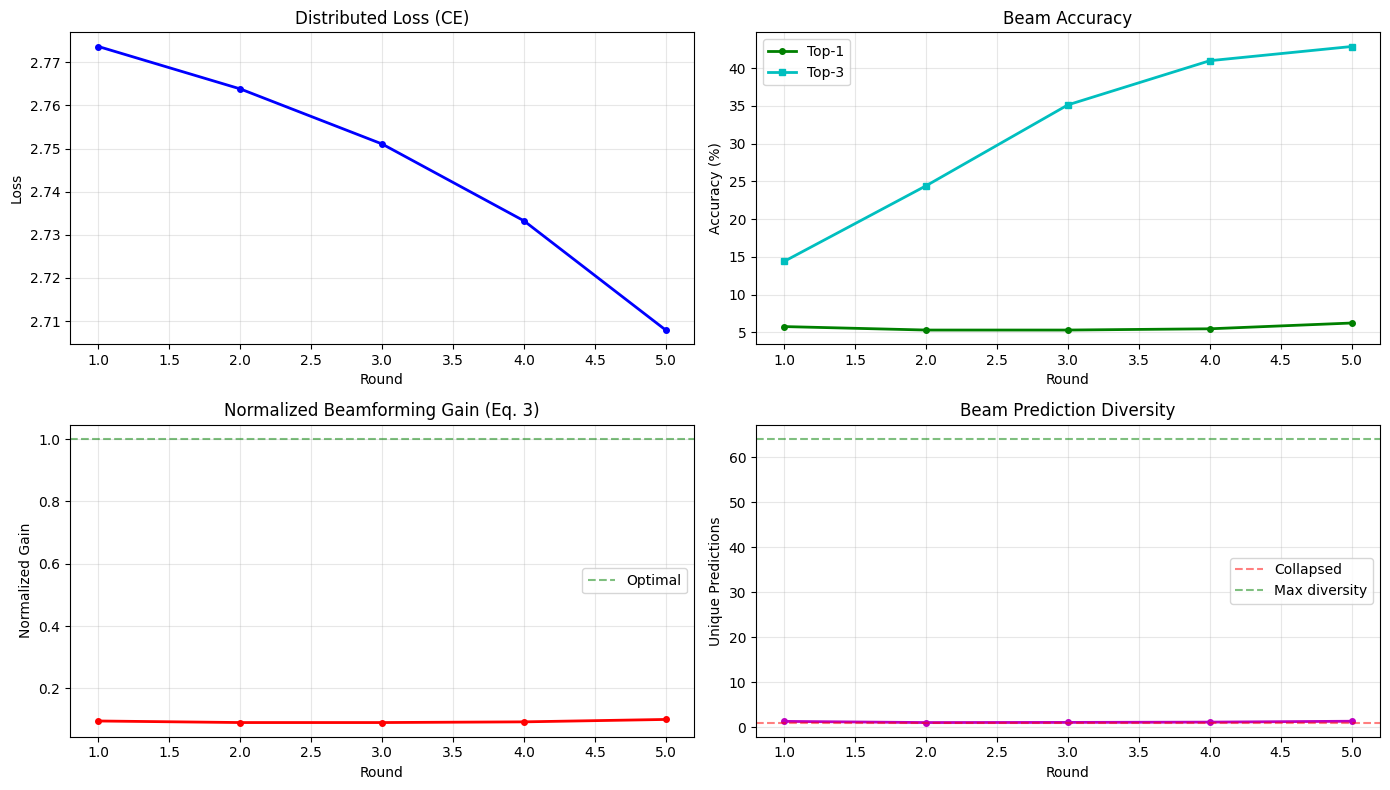

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Loss curve
if history.losses_distributed:
    rounds, losses = zip(*history.losses_distributed)
    axes[0, 0].plot(rounds, losses, "b-o", linewidth=2, markersize=4)
axes[0, 0].set_xlabel("Round"); axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Distributed Loss (CE)"); axes[0, 0].grid(True, alpha=0.3)

eval_m = history.metrics_distributed

# 2. Beam accuracy (top-1 + top-3)
if eval_m and "beam_accuracy" in eval_m:
    rds, accs = zip(*eval_m["beam_accuracy"])
    axes[0, 1].plot(rds, [a * 100 for a in accs], "g-o", linewidth=2, markersize=4, label="Top-1")
if eval_m and "beam_top3_accuracy" in eval_m:
    rds, t3 = zip(*eval_m["beam_top3_accuracy"])
    axes[0, 1].plot(rds, [a * 100 for a in t3], "c-s", linewidth=2, markersize=4, label="Top-3")
    axes[0, 1].legend()
axes[0, 1].set_xlabel("Round"); axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].set_title("Beam Accuracy"); axes[0, 1].grid(True, alpha=0.3)

# 3. Normalized Beamforming Gain (Eq. 3)
if eval_m and "normalized_gain" in eval_m:
    rds, ng = zip(*eval_m["normalized_gain"])
    axes[1, 0].plot(rds, ng, "r-o", linewidth=2, markersize=4)
    axes[1, 0].axhline(1.0, color="g", linestyle="--", alpha=0.5, label="Optimal")
    axes[1, 0].legend()
axes[1, 0].set_xlabel("Round"); axes[1, 0].set_ylabel("Normalized Gain")
axes[1, 0].set_title("Normalized Beamforming Gain (Eq. 3)"); axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction diversity
if eval_m and "beam_num_unique_preds" in eval_m:
    rds, div = zip(*eval_m["beam_num_unique_preds"])
    axes[1, 1].plot(rds, div, "m-o", linewidth=2, markersize=4)
    axes[1, 1].axhline(1, color="r", linestyle="--", alpha=0.5, label="Collapsed")
    axes[1, 1].axhline(64, color="g", linestyle="--", alpha=0.5, label="Max diversity")
    axes[1, 1].legend()
axes[1, 1].set_xlabel("Round"); axes[1, 1].set_ylabel("Unique Predictions")
axes[1, 1].set_title("Beam Prediction Diversity"); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
